# MIE 1624 Assignment #1

### **Introduction:**
In 2019, Kaggle hosted the third annual Machine Learning and Data Science Survey and the second survey data challenge. The survey included 34 questions that were designed to gain an understanding of the data science and machine learning workforce. For this assignment, the goal is to use the survey data to develop a logistic regression model that classifies a data scientist's yearly compensation bucket given a set of survey responses. The original survey dataset multiple_choice_responses.csv has been transformed to Kaggle_Salary.csv by removing all rows with missing values of salaries, combining similiar salary levels into a salary bucket, and encoding the salary buckets. A sequential workflow is to be followed to achieve the goal of this assignment, which can be divided into 6 steps: data cleaning, exploratory data analysis, feature selection, model implementation, model tuning, and testing and discussion. 

### **1. Data Cleaning:**

First of all, let's have a look of the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import scipy.io as sio
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [2]:
# Import the Kaggle_Salary dataset as pandas dataframe:
Kaggle_Salary = pd.read_csv('/Users/Joy/Desktop/Kaggle_Salary.csv',low_memory = False)
Kaggle_Salary.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"


There are 248 columns in the dataset, and each column contains responses to one or part of one survey question. The dataset recorded results from 12497 participants working in 59 countries. As the goal is to develop a logistic regression model that classifies one's yearly compensation bucket, it will be interesting to see how data science and machine learning professionals' incomes vary between different countries. However, 59 countries might be overwhelming to work with, and some countries have very small data size compare to others. Thus, 17 countries out of 59 are selected as representatives. To have a fair representation, the 8 countries will be a mix of developing and developed countries. To ensure sufficient data size for model training and validation, the following 17 countries are selected: India, Unitied States of America, China, Japan, Brazil, Canada, Germany and Russia. 

In [3]:
# Select representative countries from the original dataset and form a new dataframe:
target =((Kaggle_Salary.Q3=='India')|(Kaggle_Salary.Q3=='United States of America')|(Kaggle_Salary.Q3=='China')
        |(Kaggle_Salary.Q3=='Japan')|(Kaggle_Salary.Q3=='Brazil')|(Kaggle_Salary.Q3=='Canada')
        |(Kaggle_Salary.Q3=='Germany')|(Kaggle_Salary.Q3=='Russia')|(Kaggle_Salary.Q3=='Australia')
         |(Kaggle_Salary.Q3=='Italy')|(Kaggle_Salary.Q3=='Spain')|(Kaggle_Salary.Q3=='Nigeria')
        |(Kaggle_Salary.Q3=='Taiwan')|(Kaggle_Salary.Q3=='Turkey')|(Kaggle_Salary.Q3=='France')
        |(Kaggle_Salary.Q3=='Indonesia')|(Kaggle_Salary.Q3=='Mexico'))
Salary_target = Kaggle_Salary[target]

# Check how many data points have been selected:
Salary_target.drop_duplicates()
Salary_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8747 entries, 0 to 12496
Columns: 248 entries, Time from Start to Finish (seconds) to Q10_buckets
dtypes: int64(30), object(218)
memory usage: 16.6+ MB


There are a total of 8747 rows selected, which is sufficient for classification model development. 
Next, let's inspect each coloum. The goals are to look for missing values and to encode categorical values. 

Column "Time from Start to Finish" represents the total time span for a participant to finish the survey, which is irrelevant to the target variable yearly compensation. Therefore, the column can be dropped.

In [4]:
# Drop column 1:
Salary_target = Salary_target.drop(columns = ['Time from Start to Finish (seconds)'])

Column "Q1" represents a participant's age range. First, we check if missing values are present in this column. And next, we will encode the categorical feature using label encoding method. Each class under the feature will be converted to a number, and higher age range will be assigned higher number. 

In [5]:
# Check if there are missing values in column Q1:
Salary_target.Q1.isnull().sum()

0

No missing values present. Next, check how many classes Q1 has.

In [6]:
# Check how many unique values are in Q1:
Salary_target.Q1.unique()

array(['22-24', '40-44', '50-54', '30-34', '18-21', '35-39', '25-29',
       '45-49', '60-69', '55-59', '70+'], dtype=object)

Encode column Q1 using label encoding.

In [7]:
# Change the dtype of Q1 from object to category because encoding operation runs faster on category dtype:
Salary_target['Q1'] = Salary_target['Q1'].astype('category')

# Creat encoded variables using pandas cat.codes accessor:
Salary_target['Q1_encoded'] = Salary_target['Q1'].cat.codes

Salary_target = Salary_target.drop(columns = 'Q1',axis = 1)

Column Q2 represents the gender of participants. Similar to column Q1, Q2 is a categorical feature. First, we check if missing values are present in the column and how many classes are present under the feature. Next, we encode the categorical feature using One Hot Encoding. The advantage of using One Hot Encoding is that unlike label encoding, One Hot Encoding does not assign unfair weights to the variables. In other words, every class is represented fairly by numberical values, which is important when encoding for gender.

In [8]:
# Check if missing values are present:
print(Salary_target.Q2.isnull().sum())

# Check how many classes are under Q2:
Salary_target.Q2.unique()

0


array(['Male', 'Female', 'Prefer not to say', 'Prefer to self-describe'],
      dtype=object)

In [9]:
# Encode column Q2 using One Hot Encoding:
Salary_target = pd.get_dummies(data = Salary_target,columns=['Q2'], prefix_sep='_', drop_first=True)
Salary_target.head(3)

,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,...,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets,Q1_encoded,Q2_Male,Q2_Prefer not to say,Q2_Prefer to self-describe
0,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,...,NaN,NaN,NaN,-1,3,"30,000-39,999",1,1,0,0
1,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,...,NaN,NaN,NaN,-1,0,"0-9,999",5,1,0,0
2,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,NaN,NaN,...,NaN,NaN,NaN,-1,14,">250,000",5,1,0,0


Column Q2_other_text contains text responses regarding the gender question. However, for the purpose of privacy, Q2_other_text has been encoded, and we are not able to interprete the encoded variables. Thus, this column is not useful for classification purposes. For that reason, we will drop this column.

In [10]:
# Drop column Q2_other_text:
Salary_target = Salary_target.drop(columns = 'Q2_OTHER_TEXT',axis = 1)

Column Q3 represents the country of residency of each participants. We clean column Q3 following the exact same procedure used for Q2. 

In [11]:
# Check if missing values are present:
print(Salary_target.Q3.isnull().sum())

# Check how many classes are under Q3:
print(Salary_target.Q3.unique())

0
['France' 'India' 'Australia' 'United States of America' 'Germany'
 'Russia' 'Japan' 'Brazil' 'Nigeria' 'Mexico' 'Canada' 'Indonesia' 'Italy'
 'Spain' 'Turkey' 'Taiwan' 'China']


Here we used One Hot Encoding. Again, we treat every country fairly. 

In [12]:
# Encode column Q3 using One Hot Encoding:
Salary_target = pd.get_dummies(data = Salary_target,columns=['Q3'], prefix_sep='_', drop_first=True)
Salary_target.head(3)

,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,...,Q3_Indonesia,Q3_Italy,Q3_Japan,Q3_Mexico,Q3_Nigeria,Q3_Russia,Q3_Spain,Q3_Taiwan,Q3_Turkey,Q3_United States of America
0,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,...,0,0,0,0,0,0,0,0,0,0
2,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


Column Q4 represents the education of each participant. Column Q4 is a categorical feature, and we clean this column following the exact procedure we used for Q3.

In [13]:
# Check if missing values are present:
print(Salary_target.Q4.isnull().sum())
# Check how many classes are present:
print(Salary_target.Q4.unique())

0
['Master’s degree' 'Professional degree' 'Bachelor’s degree'
 'Doctoral degree'
 'Some college/university study without earning a bachelor’s degree'
 'I prefer not to answer' 'No formal education past high school']


In [14]:
# Encode Q4 using One Hot Encoder:
Salary_target = pd.get_dummies(data = Salary_target,columns=['Q4'], prefix_sep='_', drop_first=True)
Salary_target.head(3)

,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,...,Q3_Spain,Q3_Taiwan,Q3_Turkey,Q3_United States of America,Q4_Doctoral degree,Q4_I prefer not to answer,Q4_Master’s degree,Q4_No formal education past high school,Q4_Professional degree,Q4_Some college/university study without earning a bachelor’s degree
0,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
1,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,...,0,0,0,0,0,0,0,0,1,0
2,Other,0,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


Column Q5 represents the current job title of each participant. Column Q5 is a categorical feature, and we clean this column following the exact procedure we used for Q4.

In [15]:
# Check if missing values are present:
print(Salary_target.Q5.isnull().sum())
# Check how many classes are present:
print(Salary_target.Q5.unique())

0
['Software Engineer' 'Other' 'Data Scientist' 'Statistician'
 'Product/Project Manager' 'Data Analyst' 'Research Scientist'
 'Business Analyst' 'Data Engineer' 'DBA/Database Engineer']


In [16]:
# Encode Q5 using One Hot Encoder:
Salary_target = pd.get_dummies(data = Salary_target,columns=['Q5'], prefix_sep='_', drop_first=True)
Salary_target.head(3)

,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,...,Q4_Some college/university study without earning a bachelor’s degree,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician
0,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
1,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2,0,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0


Column Q5_other_text contains text responses regarding the job title question. However, for the purpose of privacy, Q5_other_text has been encoded, and we are not able to interprete the encoded variables. Thus, this column is not useful for classification purposes. For that reason, we will drop this column.

In [17]:
# Drop column Q5_other_text:
Salary_target = Salary_target.drop(columns = 'Q5_OTHER_TEXT',axis = 1)

Column Q6 represents the size of the participant's company. It is a categorical feature, and thus, need to be encoded. Here we use find and replace to encode column Q6. Each class under the feature is assigned a number, and larger companies with more employees with have higher number.

In [18]:
# Check if there are missing values:
print(Salary_target.Q6.isnull().sum())
# Check how many classes are present under the feature:
print(Salary_target.Q6.unique())

0
['1000-9,999 employees' '> 10,000 employees' '0-49 employees'
 '50-249 employees' '250-999 employees']


In [19]:
# Assign an unique number to each class:
replace_map = {'Q6': {'0-49 employees': 1, '50-249 employees': 2, '250-999 employees': 3, '1000-9,999 employees': 4,
                                  '> 10,000 employees': 5}}
# Find and replace the class with the number that is assigned to:
Salary_target.replace(replace_map, inplace=True)

# Drop column Q6 after encoding:
Salary_target = Salary_target.drop(columns = 'Q6',axis = 1)
Salary_target.head(3)

,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,...,Q4_Some college/university study without earning a bachelor’s degree,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician
0,0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
1,20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2,20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0


Column Q7 represents number of employees responsible for data science workload in the participant's company. It is also a categorical feature, and we clean this column following the exact procedure used for column Q6.

In [20]:
# Check if there are missing values:
print(Salary_target.Q7.isnull().sum())
# Check how many classes are present under the feature:
print(Salary_target.Q7.unique())

0
['0' '20+' '3-4' '5-9' '1-2' '10-14' '15-19']


In [21]:
# Assign an unique number to each class:
replace_map1 = {'Q7': {'0': 0, '1-2': 1, '3-4': 2, '5-9': 3, '10-14': 4, '15-19': 5, '20+': 6}}
# Find and replace the class with the number that is assigned to:
Salary_target.replace(replace_map1, inplace=True)

# Drop column Q7 after encoding:
Salary_target = Salary_target.drop(columns = 'Q7',axis = 1)
Salary_target.head(3)

,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,...,Q4_Some college/university study without earning a bachelor’s degree,Q5_DBA/Database Engineer,Q5_Data Analyst,Q5_Data Engineer,Q5_Data Scientist,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician
0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,...,0,0,0,0,0,0,0,0,1,0
1,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,...,0,0,0,0,0,0,0,0,1,0
2,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,...,0,0,0,0,0,1,0,0,0,0


Column Q8 represents participant's experience with machine learning models. To ensure a fair representation of each class under this feature, we use the One Hot Encoding method.

In [22]:
# Check if missing values are present:
print(Salary_target.Q8.isnull().sum())
# Check how many classes are present under this feature:
print(Salary_target.Q8.unique())

0
['I do not know'
 'We have well established ML methods (i.e., models in production for more than 2 years)'
 'No (we do not use ML methods)'
 'We are exploring ML methods (and may one day put a model into production)'
 'We recently started using ML methods (i.e., models in production for less than 2 years)'
 'We use ML methods for generating insights (but do not put working models into production)']


In [23]:
# Encode the feature using One Hot Encoding:
Salary_target = pd.get_dummies(data = Salary_target,columns=['Q8'], prefix_sep='_', drop_first=True)
Salary_target.head(3)

,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,...,Q5_Other,Q5_Product/Project Manager,Q5_Research Scientist,Q5_Software Engineer,Q5_Statistician,Q8_No (we do not use ML methods),Q8_We are exploring ML methods (and may one day put a model into production),"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",...,0,0,0,1,0,0,0,0,0,0
1,Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,"5,000-7,499",...,0,0,0,1,0,0,0,1,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"250,000-299,999",...,1,0,0,0,0,0,0,0,0,0


Columns Q9_Part_1 to Q9_Part_8 each represents one option of question 9. Nan value in those columns means that the participant does not select that option. Since there are only two classes under each of those columns, we can use label encoding to enocde the categorical values. 

In [24]:
# Encode columns Q9_Part_1 to Q9_Part_8 using label encoding:
Salary_target['Q9_Part_1'] = Salary_target['Q9_Part_1'].astype('category')
Salary_target['Q9_Part_1_encoded'] = Salary_target['Q9_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q9_Part_1',axis = 1)

Salary_target['Q9_Part_2'] = Salary_target['Q9_Part_2'].astype('category')
Salary_target['Q9_Part_2_encoded'] = Salary_target['Q9_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q9_Part_2',axis = 1)

Salary_target['Q9_Part_3'] = Salary_target['Q9_Part_3'].astype('category')
Salary_target['Q9_Part_3_encoded'] = Salary_target['Q9_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q9_Part_3',axis = 1)

Salary_target['Q9_Part_4'] = Salary_target['Q9_Part_4'].astype('category')
Salary_target['Q9_Part_4_encoded'] = Salary_target['Q9_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q9_Part_4',axis = 1)

Salary_target['Q9_Part_5'] = Salary_target['Q9_Part_5'].astype('category')
Salary_target['Q9_Part_5_encoded'] = Salary_target['Q9_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q9_Part_5',axis = 1)

Salary_target['Q9_Part_6'] = Salary_target['Q9_Part_6'].astype('category')
Salary_target['Q9_Part_6_encoded'] = Salary_target['Q9_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q9_Part_6',axis = 1)

Salary_target['Q9_Part_7'] = Salary_target['Q9_Part_7'].astype('category')
Salary_target['Q9_Part_7_encoded'] = Salary_target['Q9_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q9_Part_7',axis = 1)

Salary_target['Q9_Part_8'] = Salary_target['Q9_Part_8'].astype('category')
Salary_target['Q9_Part_8_encoded'] = Salary_target['Q9_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q9_Part_8',axis = 1)

Column Q9_OTHER_TEXT contains text responses to question 9. However, this column has been encoded to protect participants' privacy, and we are not able to interprete the encoded variables. Therefore, this column is not useful for classification purposes and consequently can be dropped.

In [25]:
# Drop column Q9_OTHER_TEXT:
Salary_target = Salary_target.drop(columns = 'Q9_OTHER_TEXT',axis = 1)

Column Q10 is the original yearly compensation bucket obtained directly from the survey results. Since we have already rearrange the salary bucket and created columns Q10_buckets and Q10_Encoded which is our target variable, we no long need the original column. Thus, we can simply drop it. 

In [26]:
# Drop column Q10:
Salary_target = Salary_target.drop(columns='Q10',axis = 1)

Column Q11 is a categorical feature. Following the procedure we used before, check if there are missing values in the column. In the context of Q11, a participants can fall under any categories. Replacing missing values with one of the categories is misleading. Therefore, we should remove all rows with missing values in column Q11. Lastly, encode the categorical values using find and replace method. 

In [27]:
# Check for missing values:
print(Salary_target.Q11.isnull().sum())
# Check how many classes are under this feature:
print(Salary_target.Q11.unique())

# Drop the rows with missing values:
Salary_target = Salary_target.dropna(subset=['Q11'])
# Check again if there are missing values:
Salary_target.Q11.isna().sum()

178
['$0 (USD)' '> $100,000 ($USD)' '$10,000-$99,999' '$100-$999'
 '$1000-$9,999' '$1-$99' nan]


0

In [28]:
# Assign an unique number to each of the classes:
replace_map2 = {'Q11': {'$0 (USD)': 0, '$1-$99': 1, '$100-$999': 2, '$1000-$9,999': 3, '$10,000-$99,999': 4, 
                        '> $100,000 ($USD)': 5}}
# Find and replace all the categorical varibales with the assinged number:
Salary_target.replace(replace_map2, inplace=True)

# Drop column Q11:
Salary_target = Salary_target.drop(columns = 'Q11',axis = 1)

Columns Q12_Part_1 to Q12_Part_12 each represents one option of question 12. Nan value in those columns means that the participant does not select that option. Since there are only two classes under each of those columns, we can use label encoding to enocde the categorical values. Similar to Q9_OTHER_TEXT, Q12_OTHER_TEXT can also be dropped.

In [29]:
# Drop column Q12_OTHER_TEXT:
Salary_target = Salary_target.drop(columns = 'Q12_OTHER_TEXT',axis = 1)

In [30]:
# Encode the following columns using label encoding:
Salary_target['Q12_Part_1'] = Salary_target['Q12_Part_1'].astype('category')
Salary_target['Q12_Part_1_encoded'] = Salary_target['Q12_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_1',axis = 1)

Salary_target['Q12_Part_2'] = Salary_target['Q12_Part_2'].astype('category')
Salary_target['Q12_Part_2_encoded'] = Salary_target['Q12_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_2',axis = 1)

Salary_target['Q12_Part_3'] = Salary_target['Q12_Part_3'].astype('category')
Salary_target['Q12_Part_3_encoded'] = Salary_target['Q12_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_3',axis = 1)

Salary_target['Q12_Part_4'] = Salary_target['Q12_Part_4'].astype('category')
Salary_target['Q12_Part_4_encoded'] = Salary_target['Q12_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_4',axis = 1)

Salary_target['Q12_Part_5'] = Salary_target['Q12_Part_5'].astype('category')
Salary_target['Q12_Part_5_encoded'] = Salary_target['Q12_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_5',axis = 1)

Salary_target['Q12_Part_6'] = Salary_target['Q12_Part_6'].astype('category')
Salary_target['Q12_Part_6_encoded'] = Salary_target['Q12_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_6',axis = 1)

Salary_target['Q12_Part_7'] = Salary_target['Q12_Part_7'].astype('category')
Salary_target['Q12_Part_7_encoded'] = Salary_target['Q12_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_7',axis = 1)

Salary_target['Q12_Part_8'] = Salary_target['Q12_Part_8'].astype('category')
Salary_target['Q12_Part_8_encoded'] = Salary_target['Q12_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_8',axis = 1)

Salary_target['Q12_Part_9'] = Salary_target['Q12_Part_9'].astype('category')
Salary_target['Q12_Part_9_encoded'] = Salary_target['Q12_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_9',axis = 1)

Salary_target['Q12_Part_10'] = Salary_target['Q12_Part_10'].astype('category')
Salary_target['Q12_Part_10_encoded'] = Salary_target['Q12_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_10',axis = 1)

Salary_target['Q12_Part_11'] = Salary_target['Q12_Part_11'].astype('category')
Salary_target['Q12_Part_11_encoded'] = Salary_target['Q12_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_11',axis = 1)

Salary_target['Q12_Part_12'] = Salary_target['Q12_Part_12'].astype('category')
Salary_target['Q12_Part_12_encoded'] = Salary_target['Q12_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q12_Part_12',axis = 1)

Columns Q13_Part_1 to Q13_Part_12 each represents one option of question 13. Nan value in those columns means that the participant does not select that option. Since there are only two classes under each of those columns, we can use label encoding to enocde the categorical values. Similar to Q12_OTHER_TEXT, Q13_OTHER_TEXT can also be dropped.

In [31]:
# Drop column Q13_OTHER_TEXT:
Salary_target = Salary_target.drop(columns = 'Q13_OTHER_TEXT',axis = 1)

In [32]:
# Encode the following columns using label encoding:
Salary_target['Q13_Part_1'] = Salary_target['Q13_Part_1'].astype('category')
Salary_target['Q13_Part_1_encoded'] = Salary_target['Q13_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_1',axis = 1)

Salary_target['Q13_Part_2'] = Salary_target['Q13_Part_2'].astype('category')
Salary_target['Q13_Part_2_encoded'] = Salary_target['Q13_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_2',axis = 1)

Salary_target['Q13_Part_3'] = Salary_target['Q13_Part_3'].astype('category')
Salary_target['Q13_Part_3_encoded'] = Salary_target['Q13_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_3',axis = 1)

Salary_target['Q13_Part_4'] = Salary_target['Q13_Part_4'].astype('category')
Salary_target['Q13_Part_4_encoded'] = Salary_target['Q13_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_4',axis = 1)

Salary_target['Q13_Part_5'] = Salary_target['Q13_Part_5'].astype('category')
Salary_target['Q13_Part_5_encoded'] = Salary_target['Q13_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_5',axis = 1)

Salary_target['Q13_Part_6'] = Salary_target['Q13_Part_6'].astype('category')
Salary_target['Q13_Part_6_encoded'] = Salary_target['Q13_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_6',axis = 1)

Salary_target['Q13_Part_7'] = Salary_target['Q13_Part_7'].astype('category')
Salary_target['Q13_Part_7_encoded'] = Salary_target['Q13_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_7',axis = 1)

Salary_target['Q13_Part_8'] = Salary_target['Q13_Part_8'].astype('category')
Salary_target['Q13_Part_8_encoded'] = Salary_target['Q13_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_8',axis = 1)

Salary_target['Q13_Part_9'] = Salary_target['Q13_Part_9'].astype('category')
Salary_target['Q13_Part_9_encoded'] = Salary_target['Q13_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_9',axis = 1)

Salary_target['Q13_Part_10'] = Salary_target['Q13_Part_10'].astype('category')
Salary_target['Q13_Part_10_encoded'] = Salary_target['Q13_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_10',axis = 1)

Salary_target['Q13_Part_11'] = Salary_target['Q13_Part_11'].astype('category')
Salary_target['Q13_Part_11_encoded'] = Salary_target['Q13_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_11',axis = 1)

Salary_target['Q13_Part_12'] = Salary_target['Q13_Part_12'].astype('category')
Salary_target['Q13_Part_12_encoded'] = Salary_target['Q13_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q13_Part_12',axis = 1)

Column Q14 also contains categorical values. Following the same procedure we used previously, first check for missing values. It can be seen from the output of the codes below that there are 561 missing values in this column. In the context of this column, a participant can be potentially using any of the data science and ML platforms listed. Replacing missing values with one of the platforms is misleading. Therefore, we should remove rows containing missing values in column Q14. Lastly, we can encode Q14 using One Hot Encoding.

In [33]:
# Check for missing values:
print(Salary_target.Q14.isnull().sum())
# Check for how many classes are under this column:
print(Salary_target.Q14.unique())

# Drop all rows with missing values in column Q14:
Salary_target = Salary_target.dropna(subset=['Q14'])
# Check if any missing values still exist:
Salary_target.Q14.isnull().sum()

561
['Basic statistical software (Microsoft Excel, Google Sheets, etc.)'
 'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)'
 'Local development environments (RStudio, JupyterLab, etc.)'
 'Advanced statistical software (SPSS, SAS, etc.)' 'Other'
 'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)'
 nan]


0

In [34]:
# Encode this column using One Hot Encoding:
Salary_target = pd.get_dummies(data = Salary_target,columns=['Q14'], prefix_sep='_', drop_first=True)
Salary_target.head(3)

,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,...,Q13_Part_8_encoded,Q13_Part_9_encoded,Q13_Part_10_encoded,Q13_Part_11_encoded,Q13_Part_12_encoded,"Q14_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q14_Local development environments (RStudio, JupyterLab, etc.)",Q14_Other
0,0,-1,-1,-1,-1,-1,1-2 years,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",RStudio,PyCharm,...,0,-1,-1,-1,-1,1,0,0,0,0
1,-1,-1,-1,-1,0,-1,I have never written code,NaN,NaN,NaN,...,0,-1,-1,-1,-1,0,0,1,0,0
2,-1,-1,-1,0,-1,-1,1-2 years,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",NaN,NaN,...,-1,-1,0,-1,-1,0,0,0,1,0


Columns Q14_Part_1_TEXT to Q14_OTHER_TEXT are encoded columns. Since we are not able to interprete the encoded variables, these columns are not useful for classification purposes. Therefore, we can drop these columns.

In [35]:
# Drop columns Q14_Part_1_TEXT to Q14_OTHER_TEXT:
Salary_target = Salary_target.drop(columns=['Q14_Part_1_TEXT','Q14_Part_2_TEXT','Q14_Part_3_TEXT',
                                           'Q14_Part_4_TEXT','Q14_Part_5_TEXT','Q14_OTHER_TEXT'],axis=1)

Column Q15 reperesents the year of coding experience a participant has. Following the same procedure we used for Q14. Q15 also has missing values, and rows containing missing values in Q15 are removed for the same reason discussed above. Categorical values in Q15 are encoded using the find and replace method.

In [36]:
# Check for missing values:
print(Salary_target.Q15.isnull().sum())
# Check how many classes are in Q15:
print(Salary_target.Q15.unique())

# Drop all rows with missing values in column Q15:
Salary_target = Salary_target.dropna(subset=['Q15'])
# Check if any missing values still exist:
Salary_target.Q15.isnull().sum()

20
['1-2 years' 'I have never written code' '< 1 years' '20+ years'
 '3-5 years' '5-10 years' '10-20 years' nan]


0

In [37]:
# Assign an unique number to each of the classes:
replace_map3 = {'Q15': {'I have never written code': 0, '< 1 years': 1, '1-2 years': 2, '3-5 years': 3, 
                        '5-10 years': 4, '10-20 years': 5, '20+ years': 6}}
# Find categorical values and replace them with the assigned numbers:
Salary_target.replace(replace_map3, inplace=True)

# Drop column Q15:
Salary_target = Salary_target.drop(columns = 'Q15',axis = 1)
Salary_target.head(3)

,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,...,Q13_Part_8_encoded,Q13_Part_9_encoded,Q13_Part_10_encoded,Q13_Part_11_encoded,Q13_Part_12_encoded,"Q14_Basic statistical software (Microsoft Excel, Google Sheets, etc.)","Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)","Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)","Q14_Local development environments (RStudio, JupyterLab, etc.)",Q14_Other
0,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",RStudio,PyCharm,NaN,MATLAB,NaN,Spyder,NaN,NaN,NaN,...,0,-1,-1,-1,-1,1,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,-1,-1,-1,-1,0,0,1,0,0
2,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",NaN,NaN,NaN,NaN,Visual Studio / Visual Studio Code,NaN,NaN,NaN,NaN,...,-1,-1,0,-1,-1,0,0,0,1,0


Columns Q16_Part_1 to Q18_Part_12 all have categorical values. They can be encoded using the same method used for Q13_Part_1.

In [38]:
# Encode the following columns using label encoding:
Salary_target['Q16_Part_1'] = Salary_target['Q16_Part_1'].astype('category')
Salary_target['Q16_Part_1_encoded'] = Salary_target['Q16_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_1',axis = 1)

Salary_target['Q16_Part_2'] = Salary_target['Q16_Part_2'].astype('category')
Salary_target['Q16_Part_2_encoded'] = Salary_target['Q16_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_2',axis = 1)

Salary_target['Q16_Part_3'] = Salary_target['Q16_Part_3'].astype('category')
Salary_target['Q16_Part_3_encoded'] = Salary_target['Q16_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_3',axis = 1)

Salary_target['Q16_Part_4'] = Salary_target['Q16_Part_4'].astype('category')
Salary_target['Q16_Part_4_encoded'] = Salary_target['Q16_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_4',axis = 1)

Salary_target['Q16_Part_5'] = Salary_target['Q16_Part_5'].astype('category')
Salary_target['Q16_Part_5_encoded'] = Salary_target['Q16_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_5',axis = 1)

Salary_target['Q16_Part_6'] = Salary_target['Q16_Part_6'].astype('category')
Salary_target['Q16_Part_6_encoded'] = Salary_target['Q16_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_6',axis = 1)

Salary_target['Q16_Part_7'] = Salary_target['Q16_Part_7'].astype('category')
Salary_target['Q16_Part_7_encoded'] = Salary_target['Q16_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_7',axis = 1)

Salary_target['Q16_Part_8'] = Salary_target['Q16_Part_8'].astype('category')
Salary_target['Q16_Part_8_encoded'] = Salary_target['Q16_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_8',axis = 1)

Salary_target['Q16_Part_9'] = Salary_target['Q16_Part_9'].astype('category')
Salary_target['Q16_Part_9_encoded'] = Salary_target['Q16_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_9',axis = 1)

Salary_target['Q16_Part_10'] = Salary_target['Q16_Part_10'].astype('category')
Salary_target['Q16_Part_10_encoded'] = Salary_target['Q16_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_10',axis = 1)

Salary_target['Q16_Part_11'] = Salary_target['Q16_Part_11'].astype('category')
Salary_target['Q16_Part_11_encoded'] = Salary_target['Q16_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_11',axis = 1)

Salary_target['Q16_Part_12'] = Salary_target['Q16_Part_12'].astype('category')
Salary_target['Q16_Part_12_encoded'] = Salary_target['Q16_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q16_Part_12',axis = 1)

In [39]:
# Encode the following columns using label encoding:
Salary_target['Q17_Part_1'] = Salary_target['Q17_Part_1'].astype('category')
Salary_target['Q17_Part_1_encoded'] = Salary_target['Q17_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_1',axis = 1)

Salary_target['Q17_Part_2'] = Salary_target['Q17_Part_2'].astype('category')
Salary_target['Q17_Part_2_encoded'] = Salary_target['Q17_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_2',axis = 1)

Salary_target['Q17_Part_3'] = Salary_target['Q17_Part_3'].astype('category')
Salary_target['Q17_Part_3_encoded'] = Salary_target['Q17_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_3',axis = 1)

Salary_target['Q17_Part_4'] = Salary_target['Q17_Part_4'].astype('category')
Salary_target['Q17_Part_4_encoded'] = Salary_target['Q17_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_4',axis = 1)

Salary_target['Q17_Part_5'] = Salary_target['Q17_Part_5'].astype('category')
Salary_target['Q17_Part_5_encoded'] = Salary_target['Q17_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_5',axis = 1)

Salary_target['Q17_Part_6'] = Salary_target['Q17_Part_6'].astype('category')
Salary_target['Q17_Part_6_encoded'] = Salary_target['Q17_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_6',axis = 1)

Salary_target['Q17_Part_7'] = Salary_target['Q17_Part_7'].astype('category')
Salary_target['Q17_Part_7_encoded'] = Salary_target['Q17_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_7',axis = 1)

Salary_target['Q17_Part_8'] = Salary_target['Q17_Part_8'].astype('category')
Salary_target['Q17_Part_8_encoded'] = Salary_target['Q17_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_8',axis = 1)

Salary_target['Q17_Part_9'] = Salary_target['Q17_Part_9'].astype('category')
Salary_target['Q17_Part_9_encoded'] = Salary_target['Q17_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_9',axis = 1)

Salary_target['Q17_Part_10'] = Salary_target['Q17_Part_10'].astype('category')
Salary_target['Q17_Part_10_encoded'] = Salary_target['Q17_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_10',axis = 1)

Salary_target['Q17_Part_11'] = Salary_target['Q17_Part_11'].astype('category')
Salary_target['Q17_Part_11_encoded'] = Salary_target['Q17_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_11',axis = 1)

Salary_target['Q17_Part_12'] = Salary_target['Q17_Part_12'].astype('category')
Salary_target['Q17_Part_12_encoded'] = Salary_target['Q17_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q17_Part_12',axis = 1)

In [40]:
# Encode the following columns using label encoding:
Salary_target['Q18_Part_1'] = Salary_target['Q18_Part_1'].astype('category')
Salary_target['Q18_Part_1_encoded'] = Salary_target['Q18_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_1',axis = 1)

Salary_target['Q18_Part_2'] = Salary_target['Q18_Part_2'].astype('category')
Salary_target['Q18_Part_2_encoded'] = Salary_target['Q18_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_2',axis = 1)

Salary_target['Q18_Part_3'] = Salary_target['Q18_Part_3'].astype('category')
Salary_target['Q18_Part_3_encoded'] = Salary_target['Q18_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_3',axis = 1)

Salary_target['Q18_Part_4'] = Salary_target['Q18_Part_4'].astype('category')
Salary_target['Q18_Part_4_encoded'] = Salary_target['Q18_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_4',axis = 1)

Salary_target['Q18_Part_5'] = Salary_target['Q18_Part_5'].astype('category')
Salary_target['Q18_Part_5_encoded'] = Salary_target['Q18_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_5',axis = 1)

Salary_target['Q18_Part_6'] = Salary_target['Q18_Part_6'].astype('category')
Salary_target['Q18_Part_6_encoded'] = Salary_target['Q18_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_6',axis = 1)

Salary_target['Q18_Part_7'] = Salary_target['Q18_Part_7'].astype('category')
Salary_target['Q18_Part_7_encoded'] = Salary_target['Q18_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_7',axis = 1)

Salary_target['Q18_Part_8'] = Salary_target['Q18_Part_8'].astype('category')
Salary_target['Q18_Part_8_encoded'] = Salary_target['Q18_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_8',axis = 1)

Salary_target['Q18_Part_9'] = Salary_target['Q18_Part_9'].astype('category')
Salary_target['Q18_Part_9_encoded'] = Salary_target['Q18_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_9',axis = 1)

Salary_target['Q18_Part_10'] = Salary_target['Q18_Part_10'].astype('category')
Salary_target['Q18_Part_10_encoded'] = Salary_target['Q18_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_10',axis = 1)

Salary_target['Q18_Part_11'] = Salary_target['Q18_Part_11'].astype('category')
Salary_target['Q18_Part_11_encoded'] = Salary_target['Q18_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_11',axis = 1)

Salary_target['Q18_Part_12'] = Salary_target['Q18_Part_12'].astype('category')
Salary_target['Q18_Part_12_encoded'] = Salary_target['Q18_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q18_Part_12',axis = 1)

Columns Q16_OTHER_TEXT, Q17_OTHER_TEXT and Q18_OTHER_TEXT can be dropped for the same reason we discussed previously.

In [41]:
# Drop columns:
Salary_target = Salary_target.drop(columns=['Q16_OTHER_TEXT','Q17_OTHER_TEXT','Q18_OTHER_TEXT'],axis=1)

Column Q19 represents the programming language a data scientist uses the most frequently. We clean this column following the same procedure we used before. When checking for missing values, there are 535 nan values in this column. In the context of Q19, Python is substantially more popular than any other languages. Therefore, it is reasonable to replace all nan values with Python. Categorical values in Q19 can be encoded using One Hot Encoder.

In [42]:
# Check for missing values:
print(Salary_target.Q19.isnull().sum())
# Check how many classes are under this column:
print(Salary_target.Q19.unique())
# Find out the most widly used programming language:
print(Salary_target.Q19.mode())
# Replace all nan with the most widly used programming language:
Salary_target.Q19 = Salary_target.Q19.fillna(value='Python')

535
['Python' nan 'Java' 'R' 'SQL' 'Other' 'C++' 'MATLAB' 'None' 'C'
 'Javascript' 'Bash' 'TypeScript']
0    Python
dtype: object


In [43]:
# Encode Q19 using One Hot Encoder:
Salary_target = pd.get_dummies(data = Salary_target,columns=['Q19'], prefix_sep='_', drop_first=True)

Salary_target = Salary_target.drop(columns = 'Q19_OTHER_TEXT',axis = 1)
Salary_target.head(3)

,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,...,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript
0,NaN,Matplotlib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2,Ggplot / ggplot2,Matplotlib,NaN,NaN,NaN,NaN,NaN,Seaborn,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


Columns Q20_Part_1 to Q21_Part_5 are encoded using the same method used for Q18_Part_12.

In [44]:
# Encode the following columns using label encoding:
Salary_target['Q20_Part_1'] = Salary_target['Q20_Part_1'].astype('category')
Salary_target['Q20_Part_1_encoded'] = Salary_target['Q20_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_1',axis = 1)

Salary_target['Q20_Part_2'] = Salary_target['Q20_Part_2'].astype('category')
Salary_target['Q20_Part_2_encoded'] = Salary_target['Q20_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_2',axis = 1)

Salary_target['Q20_Part_3'] = Salary_target['Q20_Part_3'].astype('category')
Salary_target['Q20_Part_3_encoded'] = Salary_target['Q20_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_3',axis = 1)

Salary_target['Q20_Part_4'] = Salary_target['Q20_Part_4'].astype('category')
Salary_target['Q20_Part_4_encoded'] = Salary_target['Q20_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_4',axis = 1)

Salary_target['Q20_Part_5'] = Salary_target['Q20_Part_5'].astype('category')
Salary_target['Q20_Part_5_encoded'] = Salary_target['Q20_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_5',axis = 1)

Salary_target['Q20_Part_6'] = Salary_target['Q20_Part_6'].astype('category')
Salary_target['Q20_Part_6_encoded'] = Salary_target['Q20_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_6',axis = 1)

Salary_target['Q20_Part_7'] = Salary_target['Q20_Part_7'].astype('category')
Salary_target['Q20_Part_7_encoded'] = Salary_target['Q20_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_7',axis = 1)

Salary_target['Q20_Part_8'] = Salary_target['Q20_Part_8'].astype('category')
Salary_target['Q20_Part_8_encoded'] = Salary_target['Q20_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_8',axis = 1)

Salary_target['Q20_Part_9'] = Salary_target['Q20_Part_9'].astype('category')
Salary_target['Q20_Part_9_encoded'] = Salary_target['Q20_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_9',axis = 1)

Salary_target['Q20_Part_10'] = Salary_target['Q20_Part_10'].astype('category')
Salary_target['Q20_Part_10_encoded'] = Salary_target['Q20_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_10',axis = 1)

Salary_target['Q20_Part_11'] = Salary_target['Q20_Part_11'].astype('category')
Salary_target['Q20_Part_11_encoded'] = Salary_target['Q20_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_11',axis = 1)

Salary_target['Q20_Part_12'] = Salary_target['Q20_Part_12'].astype('category')
Salary_target['Q20_Part_12_encoded'] = Salary_target['Q20_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q20_Part_12',axis = 1)

In [45]:
# Encode the following columns using label encoding:
Salary_target['Q21_Part_1'] = Salary_target['Q21_Part_1'].astype('category')
Salary_target['Q21_Part_1_encoded'] = Salary_target['Q21_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q21_Part_1',axis = 1)

Salary_target['Q21_Part_2'] = Salary_target['Q21_Part_2'].astype('category')
Salary_target['Q21_Part_2_encoded'] = Salary_target['Q21_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q21_Part_2',axis = 1)

Salary_target['Q21_Part_3'] = Salary_target['Q21_Part_3'].astype('category')
Salary_target['Q21_Part_3_encoded'] = Salary_target['Q21_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q21_Part_3',axis = 1)

Salary_target['Q21_Part_4'] = Salary_target['Q21_Part_4'].astype('category')
Salary_target['Q21_Part_4_encoded'] = Salary_target['Q21_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q21_Part_4',axis = 1)

Salary_target['Q21_Part_5'] = Salary_target['Q21_Part_5'].astype('category')
Salary_target['Q21_Part_5_encoded'] = Salary_target['Q21_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q21_Part_5',axis = 1)

In [46]:
# Drop columns Q20_OTHER_TEXT and Q21_OTHER_TEXT
Salary_target = Salary_target.drop(columns=['Q20_OTHER_TEXT','Q21_OTHER_TEXT'],axis=1)

Column Q22 is again, cleaned using the same procedure. When checking for missing values, Q22 has 610 missing values. In the context of Q22, 'Never' is substaintially more frequent than any other values. Therefore, it is reasonable to replace all nun with 'Never'. Categotical values in this column are encoded using the find and replace method. 

In [47]:
# Check for missing values:
print(Salary_target.Q22.isnull().sum())
# Check how many classes are under Q22:
print(Salary_target.Q22.unique())
# Check for the value that appears the most often in Q22:
print(Salary_target.Q22.mode())
# Replace nan with the mode of Q22:
Salary_target.Q22 = Salary_target.Q22.fillna('Never',inplace=True)

610
['Never' nan 'Once' '6-24 times' '2-5 times' '> 25 times']
0    Never
dtype: object


In [48]:
# Assign an unique value for each of the classes:
replace_map4 = {'Q22': {'Never': 0, 'Once': 1, '2-5 times': 2, '6-24 times': 3, 
                        '> 25 times': 4}}
# Find the categorical values and replace them with the assigned number:
Salary_target.replace(replace_map4, inplace=True)

Salary_target = Salary_target.drop(columns = 'Q22',axis = 1)

Column Q23 represents the year of ML experience a participant has. Clean column Q23 following the same procedure and encode the categorical values using the find and replace method. Nan values in Q23 are removed because in the context of Q23, the probablity of falling into each class is close. Therefore, replacing nan with a certain class can be misleading.

In [49]:
# Check for missing values:
print(Salary_target.Q23.isnull().sum())
# Check how many classes are under Q23:
print(Salary_target.Q23.unique())
# Remove all rows containing nan values under Q23:
Salary_target = Salary_target.dropna(subset=['Q23'])

614
['1-2 years' nan '2-3 years' '< 1 years' '10-15 years' '3-4 years'
 '4-5 years' '5-10 years' '20+ years']


In [50]:
# Assign an unique value for each of the classes:
replace_map5 = {'Q23': {'< 1 years': 0, '1-2 years': 1, '2-3 years': 2, '3-4 years': 3, 
                        '4-5 years': 4, '5-10 years':5, '10-15 years':6, '20+ years':7}}
# Find the categorical values and replace them with the assigned number:
Salary_target.replace(replace_map5, inplace=True)

Salary_target = Salary_target.drop(columns = 'Q23',axis = 1)

The rest of the columns can all be encoded using label encoding.

In [51]:
# Encode the following columns using label encoding:
Salary_target['Q24_Part_1'] = Salary_target['Q24_Part_1'].astype('category')
Salary_target['Q24_Part_1_encoded'] = Salary_target['Q24_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_1',axis = 1)

Salary_target['Q24_Part_2'] = Salary_target['Q24_Part_2'].astype('category')
Salary_target['Q24_Part_2_encoded'] = Salary_target['Q24_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_2',axis = 1)

Salary_target['Q24_Part_3'] = Salary_target['Q24_Part_3'].astype('category')
Salary_target['Q24_Part_3_encoded'] = Salary_target['Q24_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_3',axis = 1)

Salary_target['Q24_Part_4'] = Salary_target['Q24_Part_4'].astype('category')
Salary_target['Q24_Part_4_encoded'] = Salary_target['Q24_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_4',axis = 1)

Salary_target['Q24_Part_5'] = Salary_target['Q24_Part_5'].astype('category')
Salary_target['Q24_Part_5_encoded'] = Salary_target['Q24_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_5',axis = 1)

Salary_target['Q24_Part_6'] = Salary_target['Q24_Part_6'].astype('category')
Salary_target['Q24_Part_6_encoded'] = Salary_target['Q24_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_6',axis = 1)

Salary_target['Q24_Part_7'] = Salary_target['Q24_Part_7'].astype('category')
Salary_target['Q24_Part_7_encoded'] = Salary_target['Q24_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_7',axis = 1)

Salary_target['Q24_Part_8'] = Salary_target['Q24_Part_8'].astype('category')
Salary_target['Q24_Part_8_encoded'] = Salary_target['Q24_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_8',axis = 1)

Salary_target['Q24_Part_9'] = Salary_target['Q24_Part_9'].astype('category')
Salary_target['Q24_Part_9_encoded'] = Salary_target['Q24_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_9',axis = 1)

Salary_target['Q24_Part_10'] = Salary_target['Q24_Part_10'].astype('category')
Salary_target['Q24_Part_10_encoded'] = Salary_target['Q24_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_10',axis = 1)

Salary_target['Q24_Part_11'] = Salary_target['Q24_Part_11'].astype('category')
Salary_target['Q24_Part_11_encoded'] = Salary_target['Q24_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_11',axis = 1)

Salary_target['Q24_Part_12'] = Salary_target['Q24_Part_12'].astype('category')
Salary_target['Q24_Part_12_encoded'] = Salary_target['Q24_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q24_Part_12',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q24_OTHER_TEXT',axis = 1)

In [52]:
# Encode the following columns using label encoding:
Salary_target['Q25_Part_1'] = Salary_target['Q25_Part_1'].astype('category')
Salary_target['Q25_Part_1_encoded'] = Salary_target['Q25_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q25_Part_1',axis = 1)

Salary_target['Q25_Part_2'] = Salary_target['Q25_Part_2'].astype('category')
Salary_target['Q25_Part_2_encoded'] = Salary_target['Q25_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q25_Part_2',axis = 1)

Salary_target['Q25_Part_3'] = Salary_target['Q25_Part_3'].astype('category')
Salary_target['Q25_Part_3_encoded'] = Salary_target['Q25_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q25_Part_3',axis = 1)

Salary_target['Q25_Part_4'] = Salary_target['Q25_Part_4'].astype('category')
Salary_target['Q25_Part_4_encoded'] = Salary_target['Q25_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q25_Part_4',axis = 1)

Salary_target['Q25_Part_5'] = Salary_target['Q25_Part_5'].astype('category')
Salary_target['Q25_Part_5_encoded'] = Salary_target['Q25_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q25_Part_5',axis = 1)

Salary_target['Q25_Part_6'] = Salary_target['Q25_Part_6'].astype('category')
Salary_target['Q25_Part_6_encoded'] = Salary_target['Q25_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q25_Part_6',axis = 1)

Salary_target['Q25_Part_7'] = Salary_target['Q25_Part_7'].astype('category')
Salary_target['Q25_Part_7_encoded'] = Salary_target['Q25_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q25_Part_7',axis = 1)

Salary_target['Q25_Part_8'] = Salary_target['Q25_Part_8'].astype('category')
Salary_target['Q25_Part_8_encoded'] = Salary_target['Q25_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q25_Part_8',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q25_OTHER_TEXT',axis = 1)

In [53]:
# Encode the following columns using label encoding:
Salary_target['Q26_Part_1'] = Salary_target['Q26_Part_1'].astype('category')
Salary_target['Q26_Part_1_encoded'] = Salary_target['Q26_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q26_Part_1',axis = 1)

Salary_target['Q26_Part_2'] = Salary_target['Q26_Part_2'].astype('category')
Salary_target['Q26_Part_2_encoded'] = Salary_target['Q26_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q26_Part_2',axis = 1)

Salary_target['Q26_Part_3'] = Salary_target['Q26_Part_3'].astype('category')
Salary_target['Q26_Part_3_encoded'] = Salary_target['Q26_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q26_Part_3',axis = 1)

Salary_target['Q26_Part_4'] = Salary_target['Q26_Part_4'].astype('category')
Salary_target['Q26_Part_4_encoded'] = Salary_target['Q26_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q26_Part_4',axis = 1)

Salary_target['Q26_Part_5'] = Salary_target['Q26_Part_5'].astype('category')
Salary_target['Q26_Part_5_encoded'] = Salary_target['Q26_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q26_Part_5',axis = 1)

Salary_target['Q26_Part_6'] = Salary_target['Q26_Part_6'].astype('category')
Salary_target['Q26_Part_6_encoded'] = Salary_target['Q26_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q26_Part_6',axis = 1)

Salary_target['Q26_Part_7'] = Salary_target['Q26_Part_7'].astype('category')
Salary_target['Q26_Part_7_encoded'] = Salary_target['Q26_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q26_Part_7',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q26_OTHER_TEXT',axis = 1)

In [54]:
# Encode the following columns using label encoding:
Salary_target['Q27_Part_1'] = Salary_target['Q27_Part_1'].astype('category')
Salary_target['Q27_Part_1_encoded'] = Salary_target['Q27_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q27_Part_1',axis = 1)

Salary_target['Q27_Part_2'] = Salary_target['Q27_Part_2'].astype('category')
Salary_target['Q27_Part_2_encoded'] = Salary_target['Q27_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q27_Part_2',axis = 1)

Salary_target['Q27_Part_3'] = Salary_target['Q27_Part_3'].astype('category')
Salary_target['Q27_Part_3_encoded'] = Salary_target['Q27_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q27_Part_3',axis = 1)

Salary_target['Q27_Part_4'] = Salary_target['Q27_Part_4'].astype('category')
Salary_target['Q27_Part_4_encoded'] = Salary_target['Q27_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q27_Part_4',axis = 1)

Salary_target['Q27_Part_5'] = Salary_target['Q27_Part_5'].astype('category')
Salary_target['Q27_Part_5_encoded'] = Salary_target['Q27_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q27_Part_5',axis = 1)

Salary_target['Q27_Part_6'] = Salary_target['Q27_Part_6'].astype('category')
Salary_target['Q27_Part_6_encoded'] = Salary_target['Q27_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q27_Part_6',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q27_OTHER_TEXT',axis = 1)

In [55]:
# Encode the following columns using label encoding:
Salary_target['Q28_Part_1'] = Salary_target['Q28_Part_1'].astype('category')
Salary_target['Q28_Part_1_encoded'] = Salary_target['Q28_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_1',axis = 1)

Salary_target['Q28_Part_2'] = Salary_target['Q28_Part_2'].astype('category')
Salary_target['Q28_Part_2_encoded'] = Salary_target['Q28_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_2',axis = 1)

Salary_target['Q28_Part_3'] = Salary_target['Q28_Part_3'].astype('category')
Salary_target['Q28_Part_3_encoded'] = Salary_target['Q28_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_3',axis = 1)

Salary_target['Q28_Part_4'] = Salary_target['Q28_Part_4'].astype('category')
Salary_target['Q28_Part_4_encoded'] = Salary_target['Q28_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_4',axis = 1)

Salary_target['Q28_Part_5'] = Salary_target['Q28_Part_5'].astype('category')
Salary_target['Q28_Part_5_encoded'] = Salary_target['Q28_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_5',axis = 1)

Salary_target['Q28_Part_6'] = Salary_target['Q28_Part_6'].astype('category')
Salary_target['Q28_Part_6_encoded'] = Salary_target['Q28_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_6',axis = 1)

Salary_target['Q28_Part_7'] = Salary_target['Q28_Part_7'].astype('category')
Salary_target['Q28_Part_7_encoded'] = Salary_target['Q28_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_7',axis = 1)

Salary_target['Q28_Part_8'] = Salary_target['Q28_Part_8'].astype('category')
Salary_target['Q28_Part_8_encoded'] = Salary_target['Q28_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_8',axis = 1)

Salary_target['Q28_Part_9'] = Salary_target['Q28_Part_9'].astype('category')
Salary_target['Q28_Part_9_encoded'] = Salary_target['Q28_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_9',axis = 1)

Salary_target['Q28_Part_10'] = Salary_target['Q28_Part_10'].astype('category')
Salary_target['Q28_Part_10_encoded'] = Salary_target['Q28_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_10',axis = 1)

Salary_target['Q28_Part_11'] = Salary_target['Q28_Part_11'].astype('category')
Salary_target['Q28_Part_11_encoded'] = Salary_target['Q28_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_11',axis = 1)

Salary_target['Q28_Part_12'] = Salary_target['Q28_Part_12'].astype('category')
Salary_target['Q28_Part_12_encoded'] = Salary_target['Q28_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q28_Part_12',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q28_OTHER_TEXT',axis = 1)

In [56]:
# Encode the following columns using label encoding:
Salary_target['Q29_Part_1'] = Salary_target['Q29_Part_1'].astype('category')
Salary_target['Q29_Part_1_encoded'] = Salary_target['Q29_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_1',axis = 1)

Salary_target['Q29_Part_2'] = Salary_target['Q29_Part_2'].astype('category')
Salary_target['Q29_Part_2_encoded'] = Salary_target['Q29_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_2',axis = 1)

Salary_target['Q29_Part_3'] = Salary_target['Q29_Part_3'].astype('category')
Salary_target['Q29_Part_3_encoded'] = Salary_target['Q29_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_3',axis = 1)

Salary_target['Q29_Part_4'] = Salary_target['Q29_Part_4'].astype('category')
Salary_target['Q29_Part_4_encoded'] = Salary_target['Q29_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_4',axis = 1)

Salary_target['Q29_Part_5'] = Salary_target['Q29_Part_5'].astype('category')
Salary_target['Q29_Part_5_encoded'] = Salary_target['Q29_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_5',axis = 1)

Salary_target['Q29_Part_6'] = Salary_target['Q29_Part_6'].astype('category')
Salary_target['Q29_Part_6_encoded'] = Salary_target['Q29_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_6',axis = 1)

Salary_target['Q29_Part_7'] = Salary_target['Q29_Part_7'].astype('category')
Salary_target['Q29_Part_7_encoded'] = Salary_target['Q29_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_7',axis = 1)

Salary_target['Q29_Part_8'] = Salary_target['Q29_Part_8'].astype('category')
Salary_target['Q29_Part_8_encoded'] = Salary_target['Q29_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_8',axis = 1)

Salary_target['Q29_Part_9'] = Salary_target['Q29_Part_9'].astype('category')
Salary_target['Q29_Part_9_encoded'] = Salary_target['Q29_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_9',axis = 1)

Salary_target['Q29_Part_10'] = Salary_target['Q29_Part_10'].astype('category')
Salary_target['Q29_Part_10_encoded'] = Salary_target['Q29_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_10',axis = 1)

Salary_target['Q29_Part_11'] = Salary_target['Q29_Part_11'].astype('category')
Salary_target['Q29_Part_11_encoded'] = Salary_target['Q29_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_11',axis = 1)

Salary_target['Q29_Part_12'] = Salary_target['Q29_Part_12'].astype('category')
Salary_target['Q29_Part_12_encoded'] = Salary_target['Q29_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q29_Part_12',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q29_OTHER_TEXT',axis = 1)

In [57]:
# Encode the following columns using label encoding:
Salary_target['Q30_Part_1'] = Salary_target['Q30_Part_1'].astype('category')
Salary_target['Q30_Part_1_encoded'] = Salary_target['Q30_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_1',axis = 1)

Salary_target['Q30_Part_2'] = Salary_target['Q30_Part_2'].astype('category')
Salary_target['Q30_Part_2_encoded'] = Salary_target['Q30_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_2',axis = 1)

Salary_target['Q30_Part_3'] = Salary_target['Q30_Part_3'].astype('category')
Salary_target['Q30_Part_3_encoded'] = Salary_target['Q30_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_3',axis = 1)

Salary_target['Q30_Part_4'] = Salary_target['Q30_Part_4'].astype('category')
Salary_target['Q30_Part_4_encoded'] = Salary_target['Q30_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_4',axis = 1)

Salary_target['Q30_Part_5'] = Salary_target['Q30_Part_5'].astype('category')
Salary_target['Q30_Part_5_encoded'] = Salary_target['Q30_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_5',axis = 1)

Salary_target['Q30_Part_6'] = Salary_target['Q30_Part_6'].astype('category')
Salary_target['Q30_Part_6_encoded'] = Salary_target['Q30_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_6',axis = 1)

Salary_target['Q30_Part_7'] = Salary_target['Q30_Part_7'].astype('category')
Salary_target['Q30_Part_7_encoded'] = Salary_target['Q30_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_7',axis = 1)

Salary_target['Q30_Part_8'] = Salary_target['Q30_Part_8'].astype('category')
Salary_target['Q30_Part_8_encoded'] = Salary_target['Q30_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_8',axis = 1)

Salary_target['Q30_Part_9'] = Salary_target['Q30_Part_9'].astype('category')
Salary_target['Q30_Part_9_encoded'] = Salary_target['Q30_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_9',axis = 1)

Salary_target['Q30_Part_10'] = Salary_target['Q30_Part_10'].astype('category')
Salary_target['Q30_Part_10_encoded'] = Salary_target['Q30_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_10',axis = 1)

Salary_target['Q30_Part_11'] = Salary_target['Q30_Part_11'].astype('category')
Salary_target['Q30_Part_11_encoded'] = Salary_target['Q30_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_11',axis = 1)

Salary_target['Q30_Part_12'] = Salary_target['Q30_Part_12'].astype('category')
Salary_target['Q30_Part_12_encoded'] = Salary_target['Q30_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q30_Part_12',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q30_OTHER_TEXT',axis = 1)

In [58]:
# Encode the following columns using label encoding:
Salary_target['Q31_Part_1'] = Salary_target['Q31_Part_1'].astype('category')
Salary_target['Q31_Part_1_encoded'] = Salary_target['Q31_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_1',axis = 1)

Salary_target['Q31_Part_2'] = Salary_target['Q31_Part_2'].astype('category')
Salary_target['Q31_Part_2_encoded'] = Salary_target['Q31_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_2',axis = 1)

Salary_target['Q31_Part_3'] = Salary_target['Q31_Part_3'].astype('category')
Salary_target['Q31_Part_3_encoded'] = Salary_target['Q31_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_3',axis = 1)

Salary_target['Q31_Part_4'] = Salary_target['Q31_Part_4'].astype('category')
Salary_target['Q31_Part_4_encoded'] = Salary_target['Q31_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_4',axis = 1)

Salary_target['Q31_Part_5'] = Salary_target['Q31_Part_5'].astype('category')
Salary_target['Q31_Part_5_encoded'] = Salary_target['Q31_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_5',axis = 1)

Salary_target['Q31_Part_6'] = Salary_target['Q31_Part_6'].astype('category')
Salary_target['Q31_Part_6_encoded'] = Salary_target['Q31_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_6',axis = 1)

Salary_target['Q31_Part_7'] = Salary_target['Q31_Part_7'].astype('category')
Salary_target['Q31_Part_7_encoded'] = Salary_target['Q31_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_7',axis = 1)

Salary_target['Q31_Part_8'] = Salary_target['Q31_Part_8'].astype('category')
Salary_target['Q31_Part_8_encoded'] = Salary_target['Q31_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_8',axis = 1)

Salary_target['Q31_Part_9'] = Salary_target['Q31_Part_9'].astype('category')
Salary_target['Q31_Part_9_encoded'] = Salary_target['Q31_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_9',axis = 1)

Salary_target['Q31_Part_10'] = Salary_target['Q31_Part_10'].astype('category')
Salary_target['Q31_Part_10_encoded'] = Salary_target['Q31_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_10',axis = 1)

Salary_target['Q31_Part_11'] = Salary_target['Q31_Part_11'].astype('category')
Salary_target['Q31_Part_11_encoded'] = Salary_target['Q31_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_11',axis = 1)

Salary_target['Q31_Part_12'] = Salary_target['Q31_Part_12'].astype('category')
Salary_target['Q31_Part_12_encoded'] = Salary_target['Q31_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q31_Part_12',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q31_OTHER_TEXT',axis = 1)

In [59]:
# Encode the following columns using label encoding:
Salary_target['Q32_Part_1'] = Salary_target['Q32_Part_1'].astype('category')
Salary_target['Q32_Part_1_encoded'] = Salary_target['Q32_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_1',axis = 1)

Salary_target['Q32_Part_2'] = Salary_target['Q32_Part_2'].astype('category')
Salary_target['Q32_Part_2_encoded'] = Salary_target['Q32_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_2',axis = 1)

Salary_target['Q32_Part_3'] = Salary_target['Q32_Part_3'].astype('category')
Salary_target['Q32_Part_3_encoded'] = Salary_target['Q32_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_3',axis = 1)

Salary_target['Q32_Part_4'] = Salary_target['Q32_Part_4'].astype('category')
Salary_target['Q32_Part_4_encoded'] = Salary_target['Q32_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_4',axis = 1)

Salary_target['Q32_Part_5'] = Salary_target['Q32_Part_5'].astype('category')
Salary_target['Q32_Part_5_encoded'] = Salary_target['Q32_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_5',axis = 1)

Salary_target['Q32_Part_6'] = Salary_target['Q32_Part_6'].astype('category')
Salary_target['Q32_Part_6_encoded'] = Salary_target['Q32_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_6',axis = 1)

Salary_target['Q32_Part_7'] = Salary_target['Q32_Part_7'].astype('category')
Salary_target['Q32_Part_7_encoded'] = Salary_target['Q32_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_7',axis = 1)

Salary_target['Q32_Part_8'] = Salary_target['Q32_Part_8'].astype('category')
Salary_target['Q32_Part_8_encoded'] = Salary_target['Q32_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_8',axis = 1)

Salary_target['Q32_Part_9'] = Salary_target['Q32_Part_9'].astype('category')
Salary_target['Q32_Part_9_encoded'] = Salary_target['Q32_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_9',axis = 1)

Salary_target['Q32_Part_10'] = Salary_target['Q32_Part_10'].astype('category')
Salary_target['Q32_Part_10_encoded'] = Salary_target['Q32_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_10',axis = 1)

Salary_target['Q32_Part_11'] = Salary_target['Q32_Part_11'].astype('category')
Salary_target['Q32_Part_11_encoded'] = Salary_target['Q32_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_11',axis = 1)

Salary_target['Q32_Part_12'] = Salary_target['Q32_Part_12'].astype('category')
Salary_target['Q32_Part_12_encoded'] = Salary_target['Q32_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q32_Part_12',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q32_OTHER_TEXT',axis = 1)

In [60]:
# Encode the following columns using label encoding:
Salary_target['Q33_Part_1'] = Salary_target['Q33_Part_1'].astype('category')
Salary_target['Q33_Part_1_encoded'] = Salary_target['Q33_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_1',axis = 1)

Salary_target['Q33_Part_2'] = Salary_target['Q33_Part_2'].astype('category')
Salary_target['Q33_Part_2_encoded'] = Salary_target['Q33_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_2',axis = 1)

Salary_target['Q33_Part_3'] = Salary_target['Q33_Part_3'].astype('category')
Salary_target['Q33_Part_3_encoded'] = Salary_target['Q33_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_3',axis = 1)

Salary_target['Q33_Part_4'] = Salary_target['Q33_Part_4'].astype('category')
Salary_target['Q33_Part_4_encoded'] = Salary_target['Q33_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_4',axis = 1)

Salary_target['Q33_Part_5'] = Salary_target['Q33_Part_5'].astype('category')
Salary_target['Q33_Part_5_encoded'] = Salary_target['Q33_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_5',axis = 1)

Salary_target['Q33_Part_6'] = Salary_target['Q33_Part_6'].astype('category')
Salary_target['Q33_Part_6_encoded'] = Salary_target['Q33_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_6',axis = 1)

Salary_target['Q33_Part_7'] = Salary_target['Q33_Part_7'].astype('category')
Salary_target['Q33_Part_7_encoded'] = Salary_target['Q33_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_7',axis = 1)

Salary_target['Q33_Part_8'] = Salary_target['Q33_Part_8'].astype('category')
Salary_target['Q33_Part_8_encoded'] = Salary_target['Q33_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_8',axis = 1)

Salary_target['Q33_Part_9'] = Salary_target['Q33_Part_9'].astype('category')
Salary_target['Q33_Part_9_encoded'] = Salary_target['Q33_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_9',axis = 1)

Salary_target['Q33_Part_10'] = Salary_target['Q33_Part_10'].astype('category')
Salary_target['Q33_Part_10_encoded'] = Salary_target['Q33_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_10',axis = 1)

Salary_target['Q33_Part_11'] = Salary_target['Q33_Part_11'].astype('category')
Salary_target['Q33_Part_11_encoded'] = Salary_target['Q33_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_11',axis = 1)

Salary_target['Q33_Part_12'] = Salary_target['Q33_Part_12'].astype('category')
Salary_target['Q33_Part_12_encoded'] = Salary_target['Q33_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q33_Part_12',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q33_OTHER_TEXT',axis = 1)

In [61]:
# Encode the following columns using label encoding:
Salary_target['Q34_Part_1'] = Salary_target['Q34_Part_1'].astype('category')
Salary_target['Q34_Part_1_encoded'] = Salary_target['Q34_Part_1'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_1',axis = 1)

Salary_target['Q34_Part_2'] = Salary_target['Q34_Part_2'].astype('category')
Salary_target['Q34_Part_2_encoded'] = Salary_target['Q34_Part_2'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_2',axis = 1)

Salary_target['Q34_Part_3'] = Salary_target['Q34_Part_3'].astype('category')
Salary_target['Q34_Part_3_encoded'] = Salary_target['Q34_Part_3'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_3',axis = 1)

Salary_target['Q34_Part_4'] = Salary_target['Q34_Part_4'].astype('category')
Salary_target['Q34_Part_4_encoded'] = Salary_target['Q34_Part_4'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_4',axis = 1)

Salary_target['Q34_Part_5'] = Salary_target['Q34_Part_5'].astype('category')
Salary_target['Q34_Part_5_encoded'] = Salary_target['Q34_Part_5'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_5',axis = 1)

Salary_target['Q34_Part_6'] = Salary_target['Q34_Part_6'].astype('category')
Salary_target['Q34_Part_6_encoded'] = Salary_target['Q34_Part_6'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_6',axis = 1)

Salary_target['Q34_Part_7'] = Salary_target['Q34_Part_7'].astype('category')
Salary_target['Q34_Part_7_encoded'] = Salary_target['Q34_Part_7'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_7',axis = 1)

Salary_target['Q34_Part_8'] = Salary_target['Q34_Part_8'].astype('category')
Salary_target['Q34_Part_8_encoded'] = Salary_target['Q34_Part_8'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_8',axis = 1)

Salary_target['Q34_Part_9'] = Salary_target['Q34_Part_9'].astype('category')
Salary_target['Q34_Part_9_encoded'] = Salary_target['Q34_Part_9'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_9',axis = 1)

Salary_target['Q34_Part_10'] = Salary_target['Q34_Part_10'].astype('category')
Salary_target['Q34_Part_10_encoded'] = Salary_target['Q34_Part_10'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_10',axis = 1)

Salary_target['Q34_Part_11'] = Salary_target['Q34_Part_11'].astype('category')
Salary_target['Q34_Part_11_encoded'] = Salary_target['Q34_Part_11'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_11',axis = 1)

Salary_target['Q34_Part_12'] = Salary_target['Q34_Part_12'].astype('category')
Salary_target['Q34_Part_12_encoded'] = Salary_target['Q34_Part_12'].cat.codes
Salary_target = Salary_target.drop(columns = 'Q34_Part_12',axis = 1)

Salary_target = Salary_target.drop(columns = 'Q34_OTHER_TEXT',axis = 1)

In [62]:
# Drop column Q10_buckets
Salary_target = Salary_target.drop(columns = 'Q10_buckets',axis = 1)

### 2. Exploratory data analysis:

Now that the dataset has been cleaned and made ready-for-analysis, we can proceed to explore the dataset. Many of the categorical values have been replaced or removed during the data cleaning stage, however, plotting with original categorical values is more intuitive and makes more sense. Therefore, we will create another copy of the same data that we will work with in the following sections but with original categorical values. In addition, missing values will not be removed or replaced for exploratory data analysis. 

In [63]:
# Create a copy of the data with original categorical values:
target =((Kaggle_Salary.Q3=='India')|(Kaggle_Salary.Q3=='United States of America')|(Kaggle_Salary.Q3=='China')
        |(Kaggle_Salary.Q3=='Japan')|(Kaggle_Salary.Q3=='Brazil')|(Kaggle_Salary.Q3=='Canada')
        |(Kaggle_Salary.Q3=='Germany')|(Kaggle_Salary.Q3=='Russia')|(Kaggle_Salary.Q3=='Australia')
         |(Kaggle_Salary.Q3=='Italy')|(Kaggle_Salary.Q3=='Spain')|(Kaggle_Salary.Q3=='Nigeria')
        |(Kaggle_Salary.Q3=='Taiwan')|(Kaggle_Salary.Q3=='Turkey')|(Kaggle_Salary.Q3=='France')
        |(Kaggle_Salary.Q3=='Indonesia')|(Kaggle_Salary.Q3=='Mexico'))
Salary_exp = Kaggle_Salary[target]

Since the purpose of this analysis is to develop a logistic regression model that classifies a data scientist's yearly compensation bucket, it is important to explore the relationships between different factors and the yearly compensation. To start off, let's plot the distribution of yearly compensation of this subset of data.

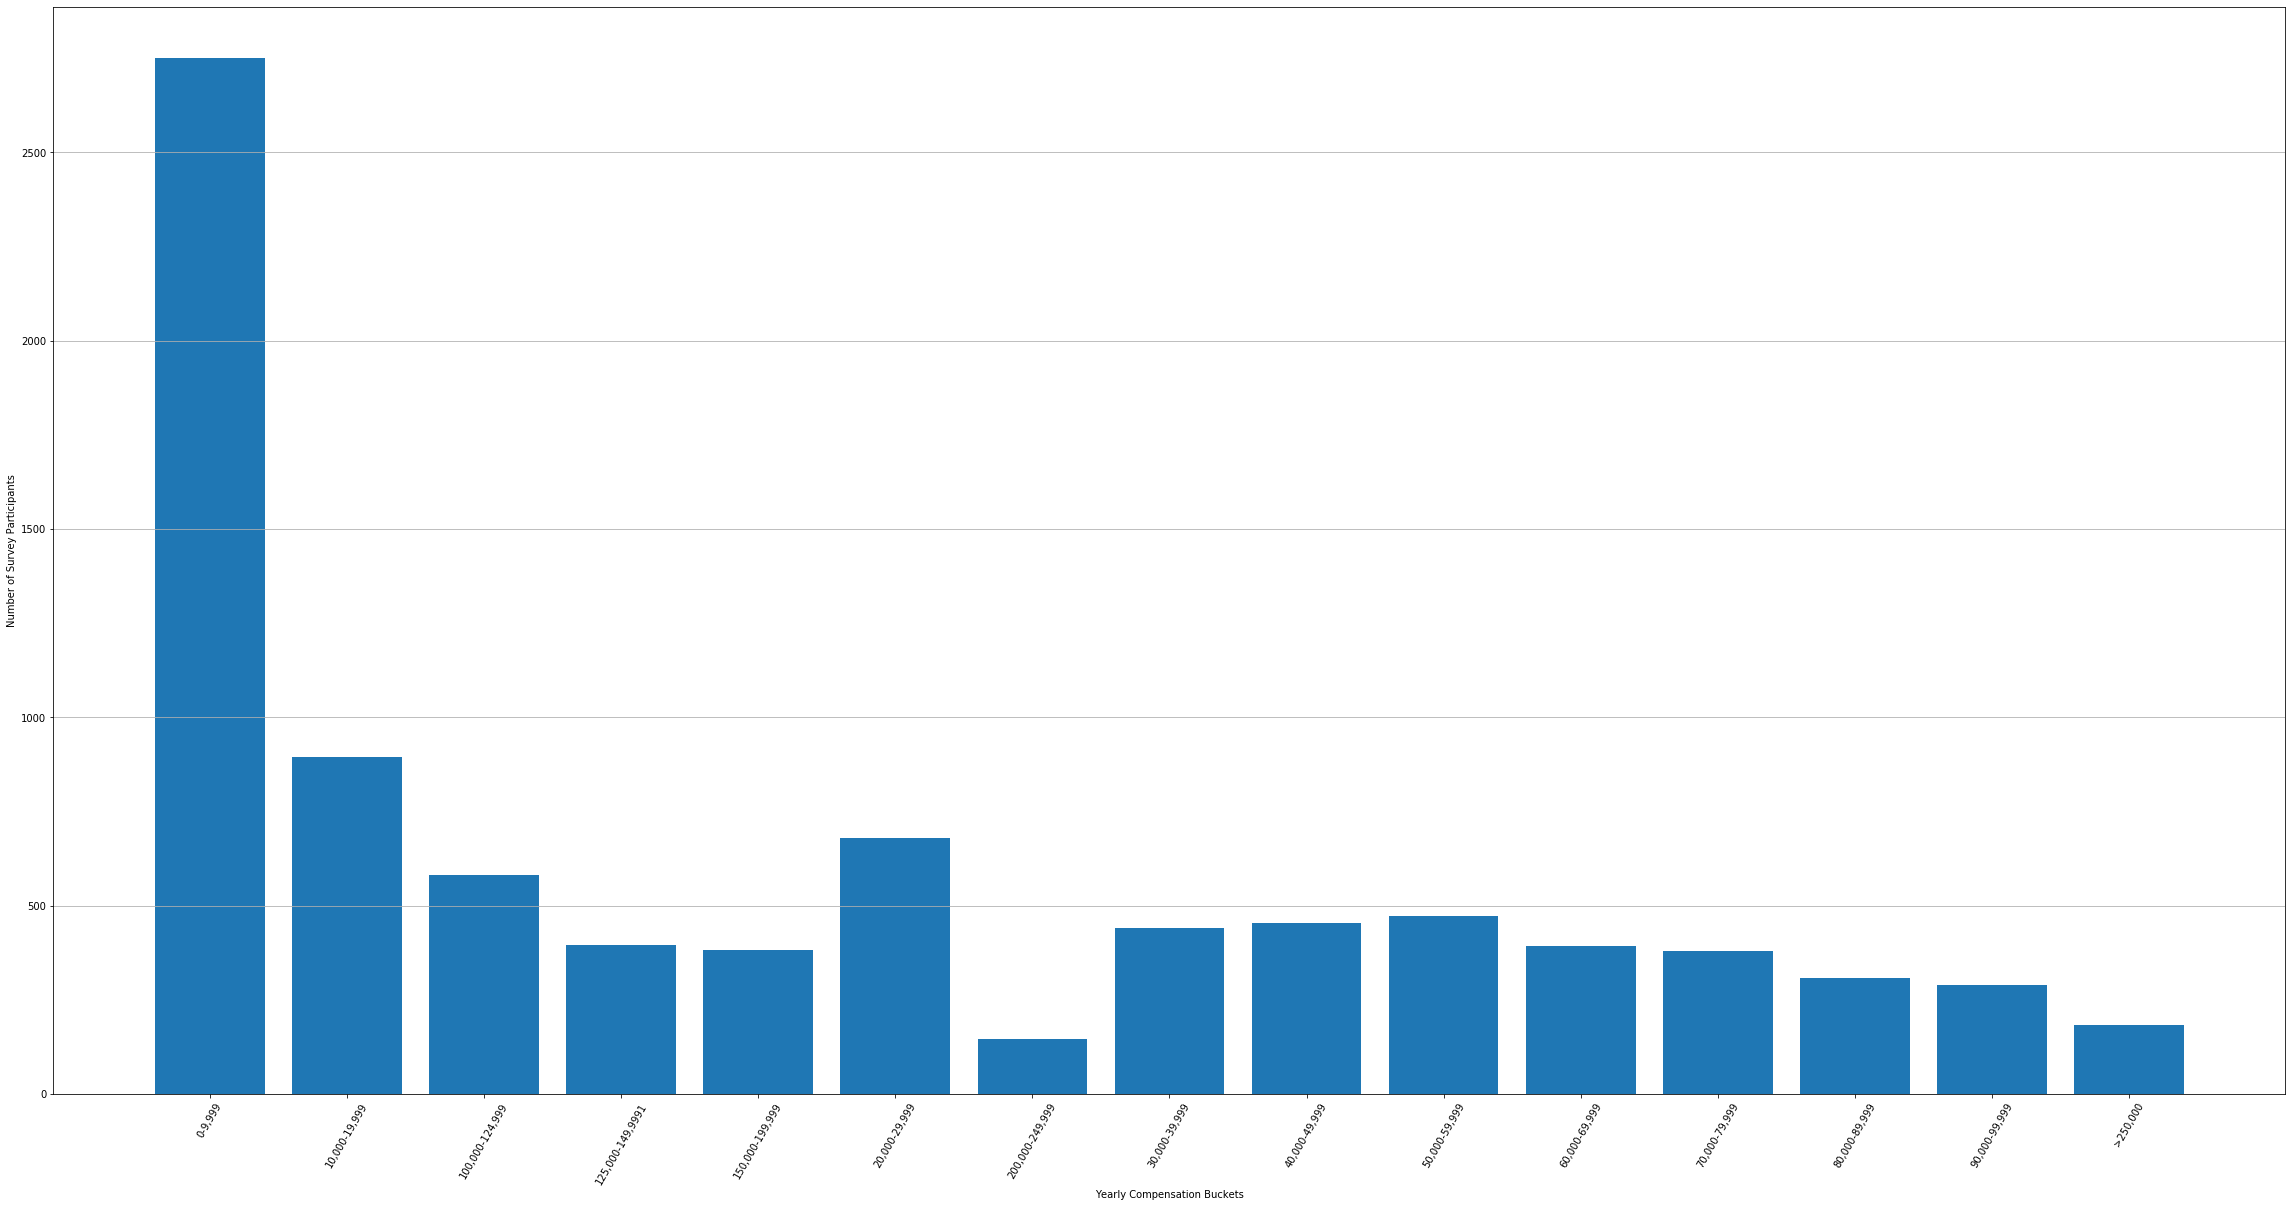

In [64]:
# Plot the bar plot of yearly compensation distribution:
plt.figure(figsize=(40,20))

#Define the X axis:
x = Salary_exp.groupby('Q10_buckets').count().index

# set height of bars
height = Salary_exp.groupby('Q10_buckets').Q1.count()

# Make the plot
plt.bar(x, height)

# Create legend & Show graphic
plt.xlabel('Yearly Compensation Buckets')
plt.ylabel('Number of Survey Participants')
plt.xticks(rotation=60)
plt.rcParams.update({'font.size': 30})
plt.grid(axis='y')
plt.show()

The bar plot above illustrates the distribution of yearly compensation buckets. It can been seen that majority of the survey responses have a yearly salary of $0-$9,999, followed by the second hightest $10,000-$19,999. In other words, most of the datapoints in this dataset fall into the lower compensation buckets. The dataset is very imbalanced. If the year of ML experience is strongly correlated to the yearly compensation buckets, it might imply that majority of the participants do not yet have rich experience with ML. We can confirm this by plotting the distribution of year of ML experience. 

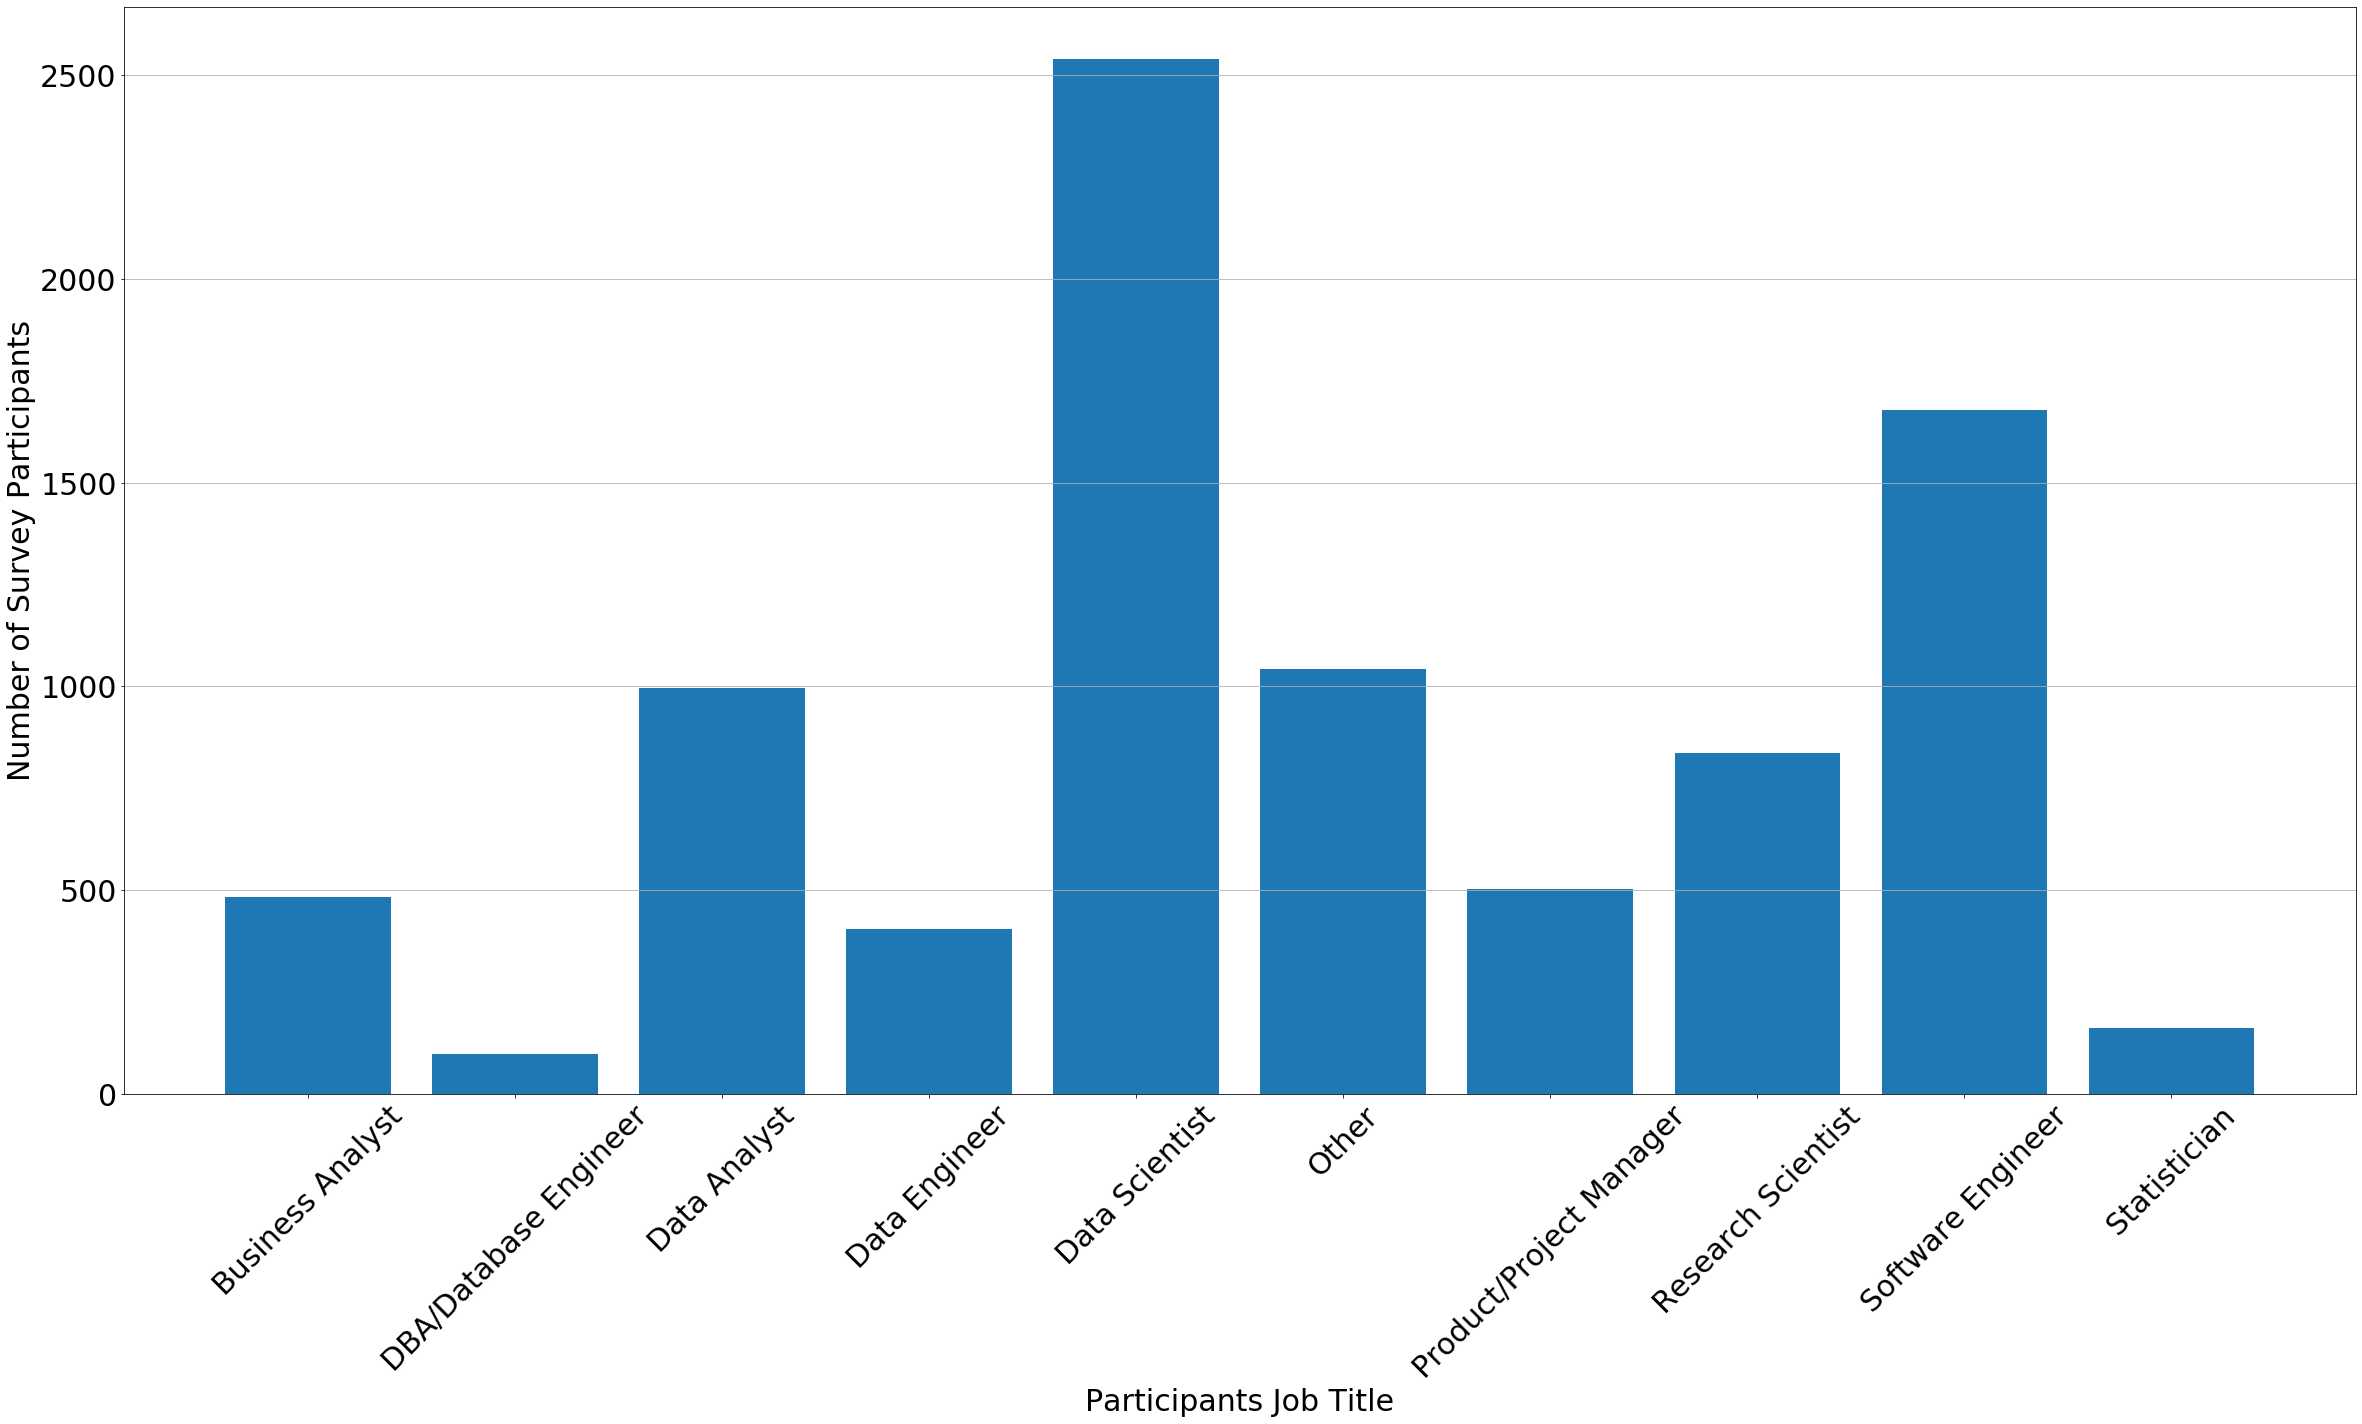

In [65]:
# Plot the bar plot of yearly compensation distribution:
plt.figure(figsize=(40,20))

#Define the X axis:
x = Salary_exp.groupby('Q5').count().index

# set height of bars
height = Salary_exp.groupby('Q5').Q1.count()

# Make the plot
plt.bar(x, height)

# Create legend & Show graphic
plt.xlabel('Participants Job Title')
plt.ylabel('Number of Survey Participants')
plt.xticks(rotation=45)
plt.rcParams.update({'font.size': 30})
plt.grid(axis='y')
plt.show()

The bar plot above illustrates the job title distribution of selected survey participants. Majority of the participants are data scientists and software engineer. Again, very imbalanced dataset.

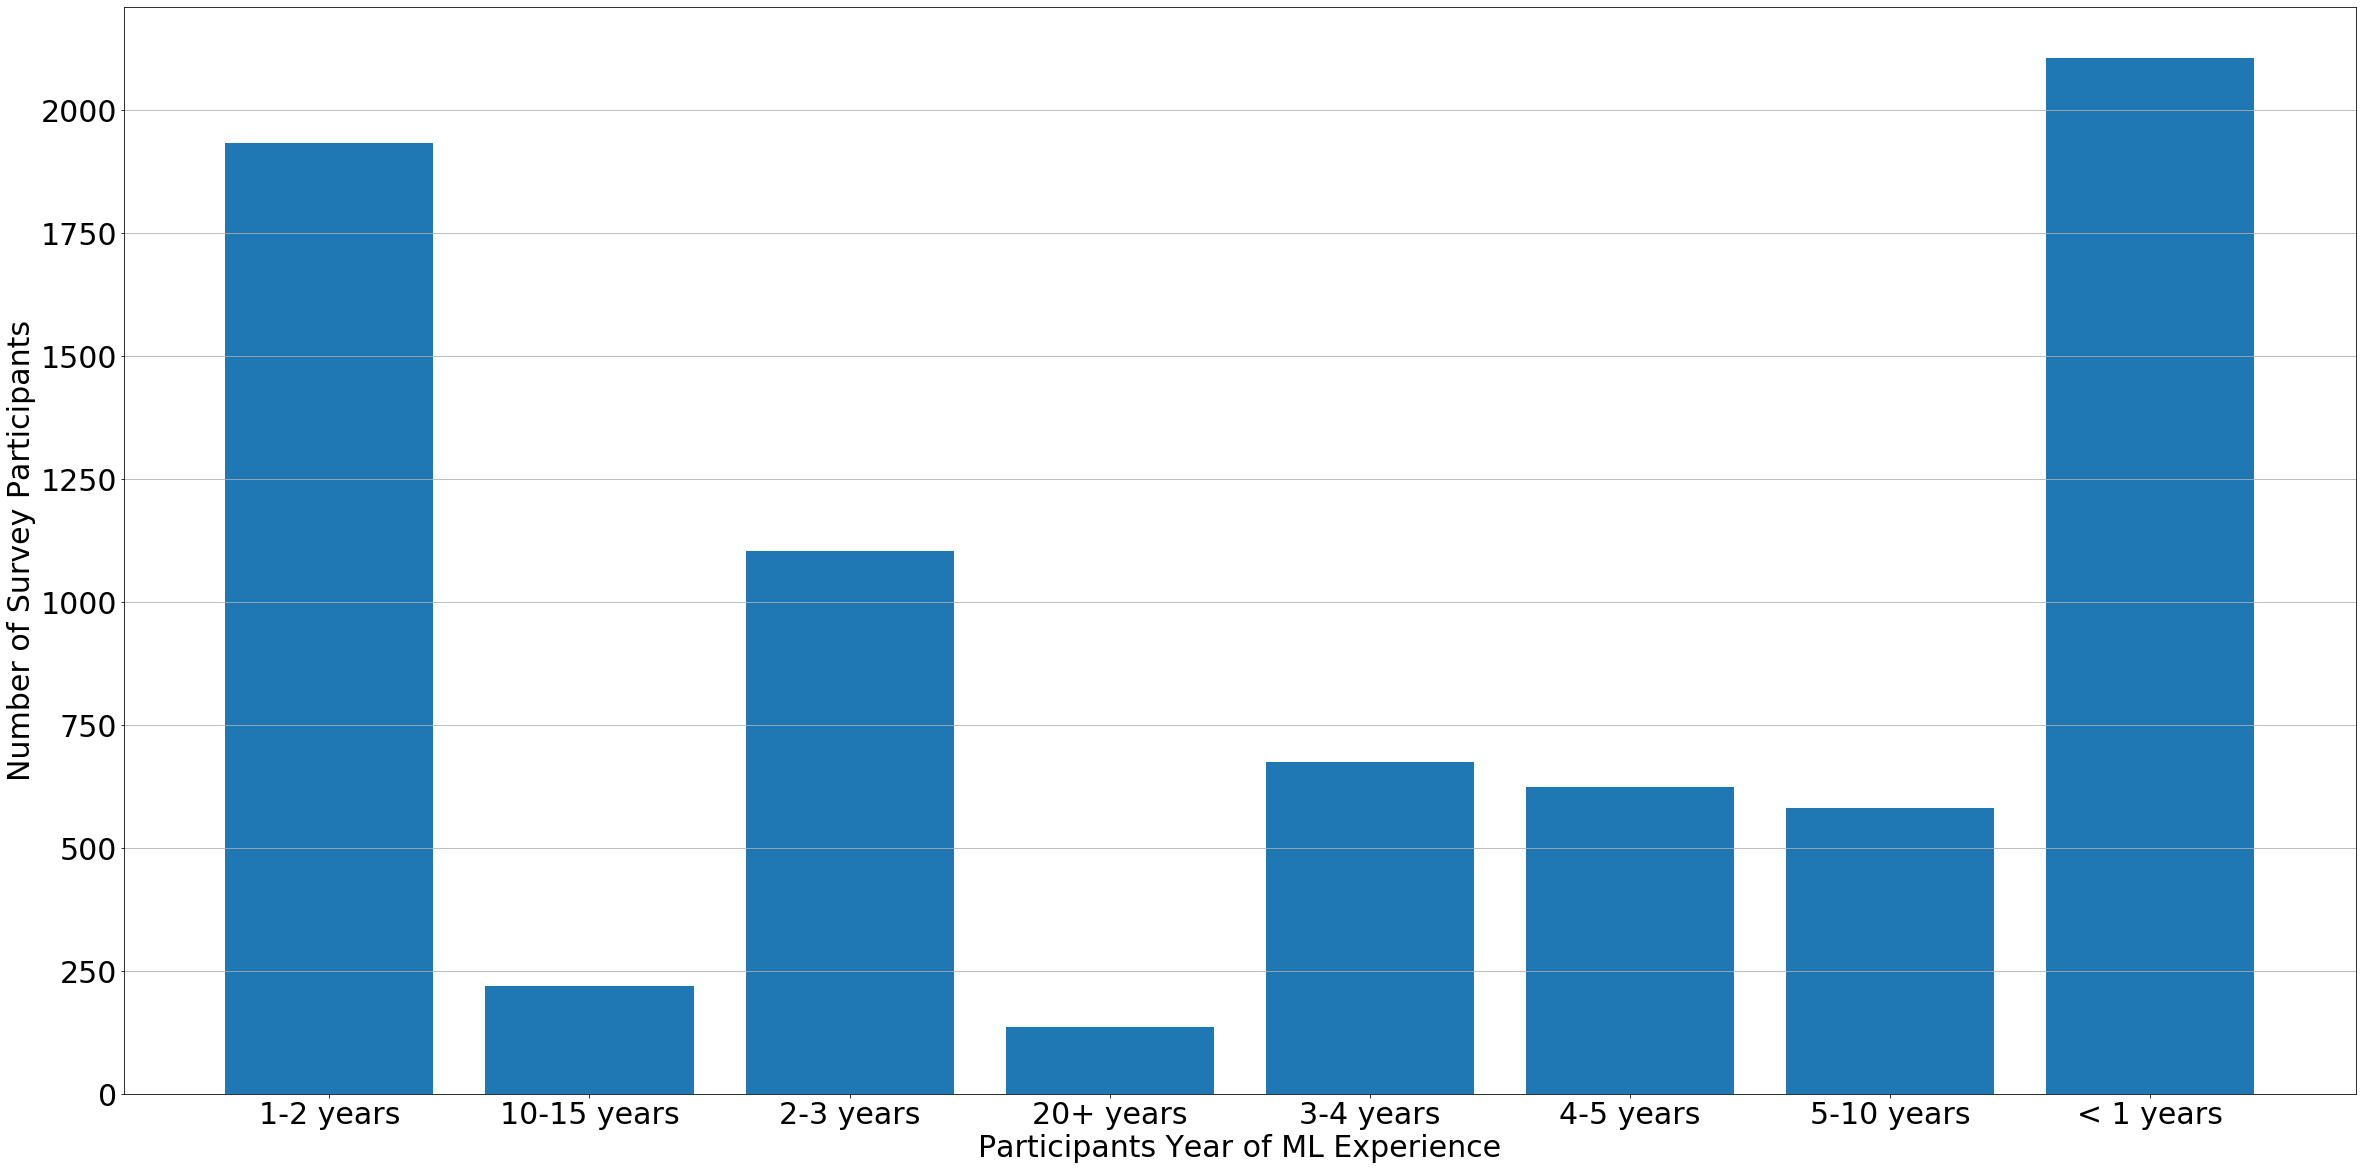

In [66]:
# Plot the distribution of year of ML experience:
plt.figure(figsize=(40,20))

#Define the X axis:
x = Salary_exp.groupby('Q23').count().index

# set height of bars
height = Salary_exp.groupby('Q23').Q1.count()

# Make the plot
plt.bar(x, height)

# Create legend & Show graphic
plt.xlabel('Participants Year of ML Experience')
plt.ylabel('Number of Survey Participants')
plt.rcParams.update({'font.size': 30})
plt.grid(axis='y')
plt.show()

The bar plot above illustrates the distribution of year of ML experience. These results agreed with our previous discussion. Majority of the participants have from less than 1 year to 3 years of ML experience. 

Next, we need to investigate the relationships between different features and the target variable, yearly compensation. We can calculate the correlation matrix of the entire dataset and plot correlation in the form of a heatmap. However, for a massive dataset like this with over 200 columns, plotting a heatmap is extremly time consuming. A significantly faster alternative to correlation plot is the Tree Based Classifier. Tree Based Classifiers take iterative processes to randomly divide the working dataset into subsets and split the data on the feature that results in the largest information gain. The process is repeated at each node until the leaves are pure. Individual trees are de-correlated to each other. In Tree Based Classifiers, correlated features will be given equal or similar importance. However, the overall importance will be reduced compared to the same tree built without correlated features. In this analysis, we choose to implement the Extra Tree Classifier. It should be noted that each Tree in the Extra Tree Classifier is constructed from the original dataset.

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


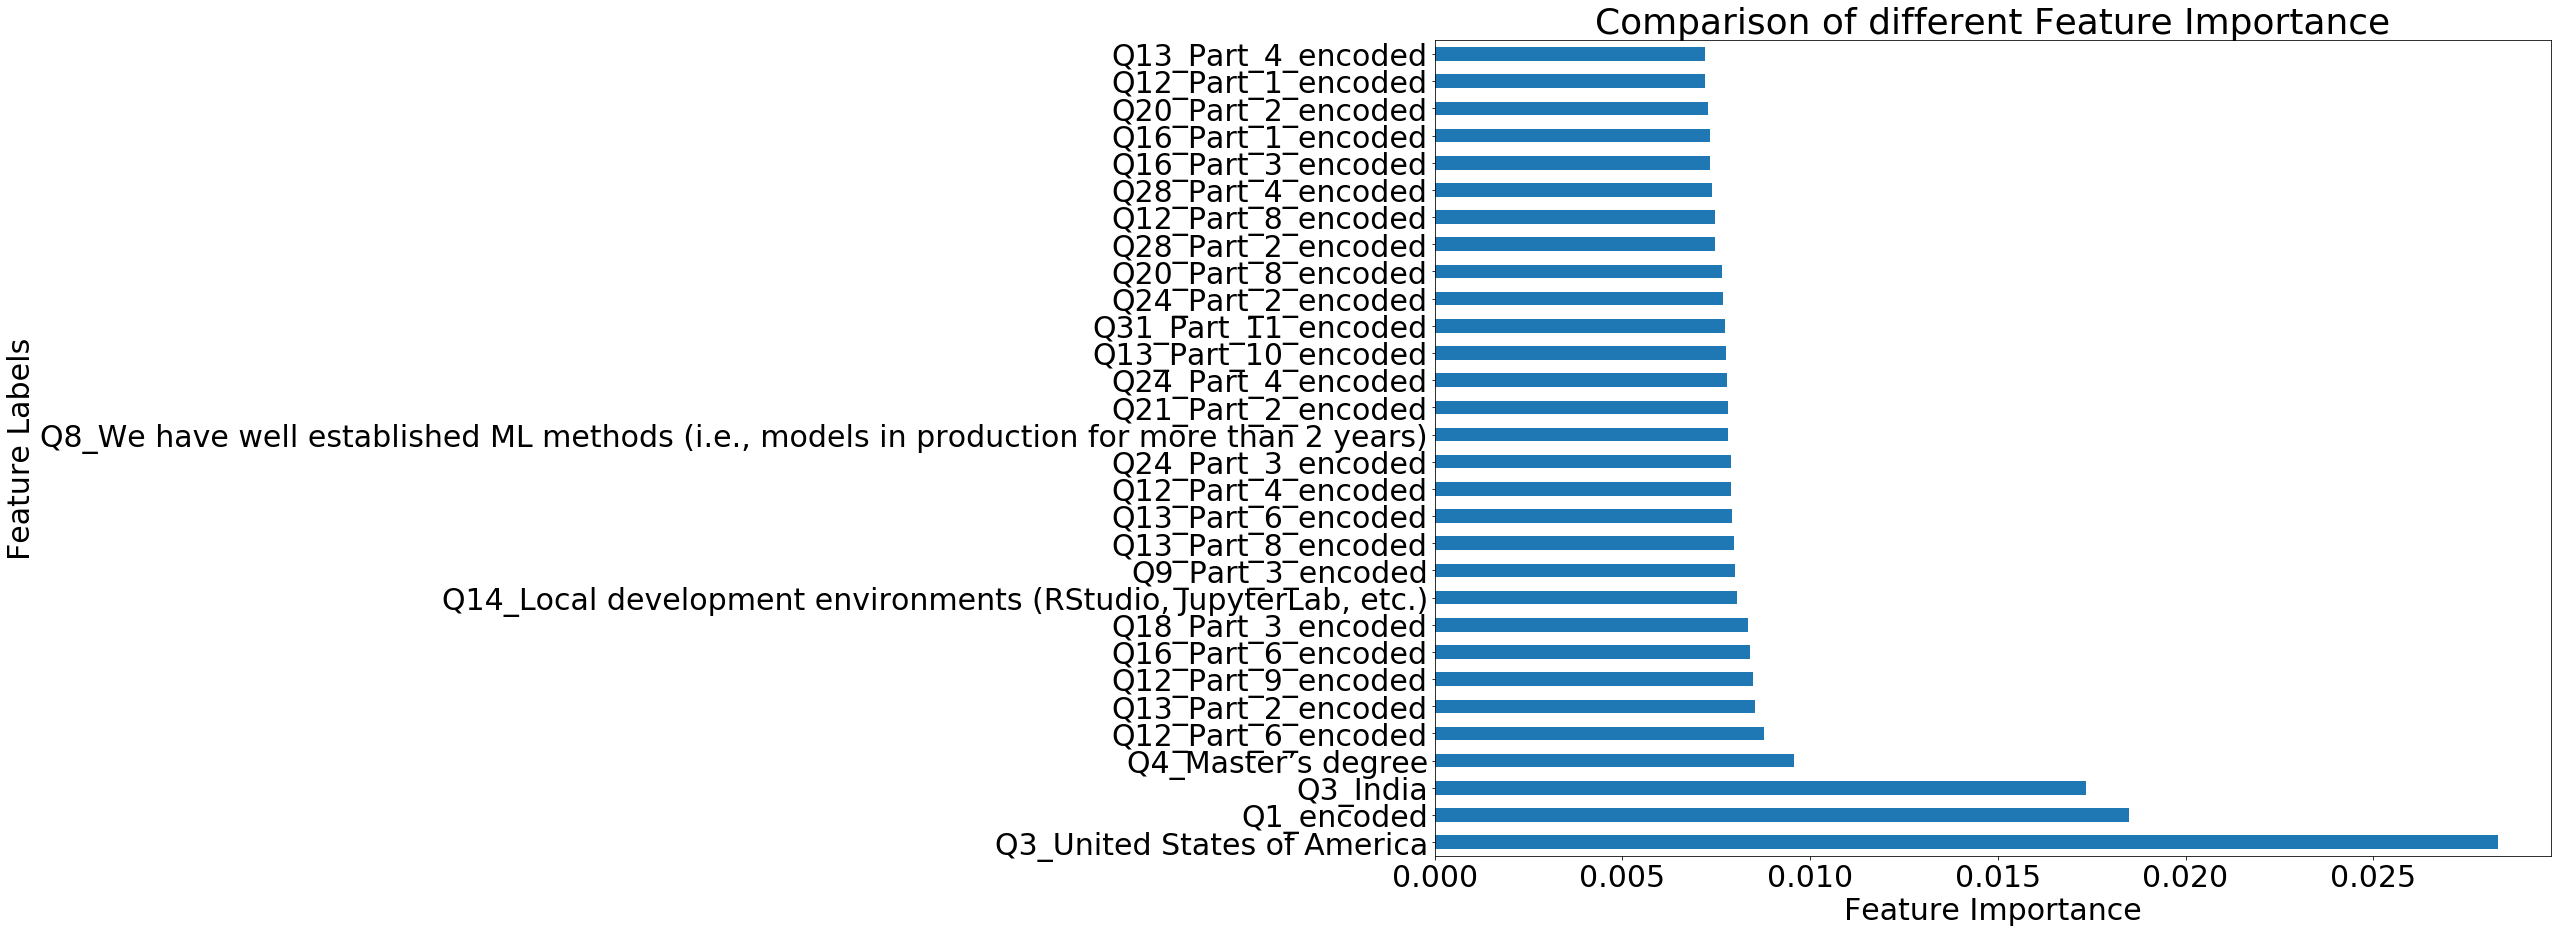

In [67]:
# Define the data and the target variable:
X = Salary_target.drop(columns=['Q10_Encoded'])
y = Salary_target['Q10_Encoded']

# Build the Extra Tree Classifier and fit the model:
model = ExtraTreesClassifier()
model.fit(X,y)

# Extract the feature importance:
feature_importance = pd.Series(model.feature_importances_, index=X.columns)

# Plot the 20 most important features:
plt.figure(figsize = (20,15))
feature_importance.nlargest(30).plot(kind='barh')
plt.xlabel('Feature Importance') 
plt.ylabel('Feature Labels') 
plt.title('Comparison of different Feature Importance') 
plt.show()

The feature importance plot above illustrates the most important 30 features that are related to the target variable, yearly compesation. Around half of the 30 features represents a survey participant's country of residency. Thus, it can be concluded that the original attribute Q3 are most realted to a survey participant's yearly compensation. Original attribute Q1 also has a relatively high importance, this is followed by Q13, Q12, Q9, and Q28.

Next, to cross check with the results obtained from Extra Trees Classifier, we can calculate the correlation matrix of the cleaned dataset and extract features that have a correlation greater than 0.2 with the target variable.

In [68]:
# Calculating the correlation matrix:
cor = Salary_target.corr()

#Correlation with the target variable:
cor_target = abs(cor["Q10_Encoded"])

#Select correlated features with greater than 0.2 correlation:
important_features = cor_target[cor_target>0.2]
important_features

Q10_Encoded                                                                                  1.000000
Q1_encoded                                                                                   0.385804
Q3_India                                                                                     0.407804
Q3_United States of America                                                                  0.635197
Q8_We have well established ML methods (i.e., models in production for more than 2 years)    0.236717
Q9_Part_1_encoded                                                                            0.206158
Q9_Part_3_encoded                                                                            0.254787
Name: Q10_Encoded, dtype: float64

The results obtained from correlation matrix roughly agrees with the results obtained from Extra Trees Classifier. Q1 and Q3 still remains the 2 most relevant features.

### 3. Feature Selection

Although now we have a sense of what features are more relevant to the target variable, we still need a more robust algorithm to select features for developing the logsitic regression model. Regularization methods take iterative steps to carefully extract features that contribute the most to the training performance at each iteration. They are the most commonly used methods which penalize a feature given a coefficient threshold. Here we use Lasso regularization for feature selection. If the feature is irrelevant, lasso penalizes it’s coefficient and makes it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [69]:
# Scale the data:
scaler = StandardScaler()
scaler.fit(X)

# Create and fit Lasso regularization model:
Lasso_reg = LassoCV()
Lasso_reg.fit(X, y)

# Obtain the coeffecient of each feature:
coef = pd.Series(Lasso_reg.coef_, index = X.columns)

# Check how many features are selected and how many features are removed:
print("Lasso selected " + str(sum(coef != 0)) + " variables and removed the other " +  str(sum(coef == 0)) + " variables")

# Creat a new dataset for logistic regression with only the selected features:
feature_remove = coef[coef == 0].index
Salary_classif = Salary_target.drop(columns=feature_remove, axis=1)


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Lasso selected 182 variables and removed the other 76 variables


After performing feature selection using Lasso regularization, we still have 182 features to work with. Therefore, principle component analysis (PCA) should be conducted to effectively reduce the dimensionality of the dataset so that we can speed up the fitting of logistic regression model later.

In [70]:
# Define the data and the target variable:
X = Salary_classif.drop(columns=['Q10_Encoded'])
y = Salary_classif['Q10_Encoded']

# Train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize the data:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Create the PCA model which captures 95% of the variance:
pca = PCA(.95)

# Fit the PCA model to the training dataset:
pca.fit(X_train)

# Transform the training and testing datasets:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

### 4. Model Implementation

Now that we have split the entire dataset into traing data and testing data and scaled the data as necessay. A PCA model is fitted to the training dataset and is used to transform both the training and testing data. Next, we could start implementing the logistic regression model. Since the output of the model should be the probability of belonging to one of the salary buckets, the multi-class classification method is set to one over the rest. In other words, a binary logistic regression model is developed and is repeated for 15 times for a given set of responses. 

In [71]:
# Create the logistic regression model:
# Since the output of the algorithm should be a probability of belonging to each of the salary buckert,
# the One-over-rest method is selected:
logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
logreg.fit(X_train, y_train)

# Fit the logistic regression model to training data using 10-fold cross-validation:
# accuracy = cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy')
# print (accuracy)
# Calculate the mean and s.d. of the accuracy
# mean = accuracy.mean(), 
# s.d. = accuracy.std() 
print("Average accuracy: 0.32 (+/- 0.03)")

Average accuracy: 0.32 (+/- 0.03)


The model accuracy does not vary significantly across folds. The first fold has the lowest accuracy which is 0.3027, and the 8th fold has the highest accuracy which is 0.3411. Overall, the average accuracy for all folds is 0.32, and the standard deviation is 0.03. Treating each value of hyperparameters as a new model, judging from the accuracy metric, the 8th model performs the best.

In [74]:
# Predict the target variable using test set:
y_pred = logreg.predict(X_test) 

# Calculate the accuracy:
from sklearn.metrics import accuracy_score
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))

Accuracy Score : 0.3131495707184817


### 5. Model Tuning

Lastly, we need to tune the hyperparameters of the logistic regression model. Hyperparameters are parameters that are not directly learned by the estimators. A effective way of tuning hyperparameters is grid search. To implement grid search, we use GridSearchCV. For this particular classification problem, we are interested in the overall number of correct classifications, no matter it is true positive or true negative. Therefore, accuracy will be a fair metric to measure the performance of the model.

In [75]:
# Create Grid Search:
from sklearn.model_selection import GridSearchCV
#classifier = LogisticRegression()
#grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25],'solver':['saga'],'multi_class':['ovr','multinomial']}
#grid_acc = GridSearchCV(classifier, param_grid = grid_values,scoring = 'accuracy')
#grid_acc.fit(X_train, y_train)

The grid search code block takes a very long time to run, and thus, is commented for convinence.

### 6. Testing and Discussion

Now that we have got the final model by grid search. Let's use the final model to make predictions. However, since the codes for the final model have been commented, the following codes have to be commented as well. The accuracy score will be recorded.

In [76]:
# Predict target variables using testing data and the final model:
#y_test_pred = grid_acc.predict(X_test)

# Calculate the accuracy:
#print('Accuracy Score : ' + str(accuracy_score(y_test,y_test_pred)))

In [77]:
# Model performance on the training dataset:
#y_train_pred = grid_acc.predict(X_train)

# Calculate the accuracy:
#print('Accuracy Score : ' + str(accuracy_score(y_train,y_train_pred)))

The accuray score of the final model when fitting the testing dataset is 0.329, while the accuracy of the final model when fitting the training dataset is 0.401. It is expected that the model will perform better with the training dataset. The previous model developed using default hyperparameters has an accuracy of 0.313 with testing dataset, essentially the same as the final model. Since the model does not have a high accuracy even on training dataset, the model might be underfitting, which also explains why it generalizes poorly to unseen dataset. A reason why the final model generalizes so poorly on unseen dataset is that the training dataset is very imbalanced, as illustrated in the exploratory analysis. Therefore, to improve model performance, resampling and creating a balanced dataset is critical.